In [3]:
import re
import os
import numpy as np
import pandas as pd
from sklearn.pipeline import *
from sklearn.metrics import *
from sklearn.cluster import *
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.feature_extraction.text import *
from sklearn.preprocessing import Normalizer, LabelEncoder

## Cleaning corpus

In [6]:
def preprocess(text):
    text = re.sub(r"\n(\s*?)¶*(\d)+~*\]", r"\n", text)  # removes line numbers
    text = re.sub(r"\.[il]\.", r"ed ón", text) # changes .i., .l. to 'ed ón'
    text = re.sub(r"(\[.*?\])|(Text\s.*?\n)|((\.|\s)[ivxUuírcfl]+?\.)|(\.|\s)[A-Z]\.|sic\."
                  r"|(Incipit|Finit|FINIT|FINIS|Amen|anno\sdomini|dixit)[.,\n\s]*", r"", text)  # removes Latin & editor's comments
    text = re.sub(r"(\w|[.:;,-?!’])\s([.:;,-?!’])", r"\1\2", text) # removes whitespaces between words and punctuation
    text = re.sub(r"p\.((\s|\n)*)\d+(\s|\n)*?", r"", text)  # removes page numbers
    text = re.sub(r"\{(.+?)\}\s*?", r"", text)  # removes MS folios
    text = re.sub(r"(\.|[a-z])\d*(\n|\s)", r"\1\2", text)  # removes footnote numbers
    text = re.sub(r"^l|l^", "", text) # removes these weird things
    text = re.sub(r"(\.|\.’|’|,)(‘|\w)", r"\1 \2", text)  # adds necessary whitespaces
    text = re.sub(r"([.?!]’*)(\s|‘)", r"\1\n\2", text)  # moves each sentence to a new line
    text = re.sub(r"(\w|,|&|-|\s|;)\n", r"\1 ", text)  # joins sentence parts that were on different lines
    text = re.sub(r"(\n|\s|-|‘)\s+(\w|&|[’'.:;,-?!]*|\n)", r"\1\2", text)  # removes unnecessary whitespaces
    text = re.sub(r"~|§|\[|\]|\(|\)|\|", r"",text)  # removes unnecessary symbols
    text = re.sub(r"\s-(\w+)", r"-\1", text) # removes whitespaces before dashes
    text = re.sub(r"(\w+)-\s", r"\1-", text) # removes whitespaces after dashes
    return text

def process_files(path):
    for root, dirs, files in os.walk(path):
        for file in files:
            with open(os.path.join(root, file), 'r', encoding='utf-8') as f:
                text = preprocess(f.read())
            with open(os.path.join(root, file), 'w', encoding='utf-8') as f1:
                f1.write(text)

In [89]:
%time process_files('./corpus')

Wall time: 13.3 s


## Adding metadata

In [47]:
data = []

for root, dirs, files in os.walk('./working_corpus'):
    for file in files:
        with open(os.path.join(root, file), 'r', encoding='utf-8') as f:
            data.append([file, f.read()])

df = pd.DataFrame(data, columns=['filename', 'text'])
df.head()

,filename,text
0,A bairgen ataí i ngábud.txt,A bairgen ataí i ngábud In gilla A Bairgen ata...
1,A ben bennacht fort na raid.txt,A ben bennacht fort na raid Atrubairt Daniel h...
2,A Chóicid chóem Chairpri chrúaid.txt,A Chóicid chóem Chairpri chrúaid Orthanach hua...
3,Acallam na Senórach.txt,Ar tabhuirtt chatha Chomuir & chatha Gabra & c...
4,Aided Cheltchair meic Uthechair.txt,Aided Cheltchair meic Uthechair CId dia ta Aid...


In [48]:
df.sort_values('filename', inplace=True)
df.reset_index(inplace=True, drop=True)
df.head()

,filename,text
0,A Chloch thall for elaid úair.txt,Cinaed hua Artacain cecinit.\nA Chloch thall f...
1,A Chormaic coisc do maicni.txt,A Chormaic coisc do maicni A Chormaic coisc do...
2,A Chóicid chóem Chairpri chrúaid.txt,A Chóicid chóem Chairpri chrúaid Orthanach hua...
3,A Gillu gairm n-ilgrada.txt,Fland Manistrech cecinit A Gillu gairm n-ilgra...
4,A Maccáin ná cí.txt,Ailill Ólomm: A Maccáin ná cí A Maccáin ná cí ...


In [59]:
meta = pd.read_csv('corpus_metatable_no_compilations.csv', sep=';', encoding='utf-8')
meta = meta.fillna('—')

In [60]:
meta.sort_values('Title', inplace=True)
meta.reset_index(inplace=True, drop=True)
meta.head()

,Title,Editor,Size (words),Real size (tokens),Dates,Language,Form,Genre,Subgenre,Group,Author,Link,Comment
0,A Chloch thall for elaid úair,Richard Irvine Best; M.A. O'Brien,—,200,1150–1216,Middle Irish,Verse,—,—,—,Cinaed hua Artacain,https://celt.ucc.ie/published/G800011C/text027...,Lebar na Núachongbála (C)
1,A Chormaic coisc do maicni,Richard Irvine Best; M.A. O'Brien,—,720,1150–1212,Middle Irish,Verse,—,—,—,Unknown,https://celt.ucc.ie/published/G800011C/text023...,Lebar na Núachongbála (C)
2,A Chóicid chóem Chairpri chrúaid,Richard Irvine Best; Osborn Bergin,—,374,1150–1224,Middle Irish,Verse,—,—,—,Unknown,https://celt.ucc.ie//published/G800011A/text03...,Lebar na Núachongbála (A)
3,A Gillu gairm n–ilgrada,Richard Irvine Best; Osborn Bergin,—,574,1150–1195,Middle Irish,Verse,—,—,—,Fland Manistrech,https://celt.ucc.ie//published/G800011A/text00...,Lebar na Núachongbála (A)
4,A Maccáin ná cí,Richard Irvine Best; M.A. O'Brien,—,1101,1150–1206,Middle Irish,Verse,—,—,—,Ailill Ólomm,https://celt.ucc.ie/published/G800011C/text017...,Lebar na Núachongbála (C)


In [61]:
meta.tail()

,Title,Editor,Size (words),Real size (tokens),Dates,Language,Form,Genre,Subgenre,Group,Author,Link,Comment
324,Verba Scáthaige,Rudolf Thurneysen,960,164,600–900,Old Irish,Prosimetry,Narrative,—,Ulster cycle,Unknown,https://celt.ucc.ie//published/G301032,"Турнейзен — ненадежный редактор, много наиспра..."
325,"Verschiedenes aus Harley 5280, fol. 57b",Kuno Meyer,665,147,900–1200,Middle Irish,Prose,Narrative,—,Ulster cycle,Unknown,https://celt.ucc.ie//published/G301030/,"На редакцию Куно Мейера можно полагаться, не д..."
326,Áirem Muintire Finn,Standish Hayes O'Grady,1080,2940,1100–1200,Middle Irish,Prose,Narrative,—,Fenian cycle,Unknown,https://celt.ucc.ie//published/G303019/,
327,Óenach Talten,Richard Irvine Best; M.A. O'Brien,—,76,1150–1197,Middle Irish,Prose,Narrative,—,—,Unknown,https://celt.ucc.ie//published/G800011E/text01...,Lebar na Núachongbála (E)
328,Úar in lathe do Lum Luine,Richard Irvine Best; M.A. O'Brien,—,167,1150–1200,Middle Irish,Verse,—,—,—,Unknown,https://celt.ucc.ie/published/G800011C/text011...,Lebar na Núachongbála (C)


In [62]:
df.tail()

,filename,text
324,Verba Scáthaige.txt,Verba Scáthaige Incipiunt uerba Scathaige fri ...
325,"Verschiedenes aus Harley 5280, fol. 57b.txt","Sencha mac Ailella, is é ba brethim & ba sench..."
326,Áirem Muintire Finn.txt,Áirem Muintire Finn Airem muintiri Finn in so....
327,Óenach Talten.txt,Óenach Talten Ferthair Oenach Talten la Diarma...
328,Úar in lathe do Lum Luine.txt,Úar in lathe do Lum Luine Úar in lathe do Lum ...


In [63]:
data = meta.copy()
data['Text'] = df['text']
data.head()

,Title,Editor,Size (words),Real size (tokens),Dates,Language,Form,Genre,Subgenre,Group,Author,Link,Comment,Text
0,A Chloch thall for elaid úair,Richard Irvine Best; M.A. O'Brien,—,200,1150–1216,Middle Irish,Verse,—,—,—,Cinaed hua Artacain,https://celt.ucc.ie/published/G800011C/text027...,Lebar na Núachongbála (C),Cinaed hua Artacain cecinit.\nA Chloch thall f...
1,A Chormaic coisc do maicni,Richard Irvine Best; M.A. O'Brien,—,720,1150–1212,Middle Irish,Verse,—,—,—,Unknown,https://celt.ucc.ie/published/G800011C/text023...,Lebar na Núachongbála (C),A Chormaic coisc do maicni A Chormaic coisc do...
2,A Chóicid chóem Chairpri chrúaid,Richard Irvine Best; Osborn Bergin,—,374,1150–1224,Middle Irish,Verse,—,—,—,Unknown,https://celt.ucc.ie//published/G800011A/text03...,Lebar na Núachongbála (A),A Chóicid chóem Chairpri chrúaid Orthanach hua...
3,A Gillu gairm n–ilgrada,Richard Irvine Best; Osborn Bergin,—,574,1150–1195,Middle Irish,Verse,—,—,—,Fland Manistrech,https://celt.ucc.ie//published/G800011A/text00...,Lebar na Núachongbála (A),Fland Manistrech cecinit A Gillu gairm n-ilgra...
4,A Maccáin ná cí,Richard Irvine Best; M.A. O'Brien,—,1101,1150–1206,Middle Irish,Verse,—,—,—,Ailill Ólomm,https://celt.ucc.ie/published/G800011C/text017...,Lebar na Núachongbála (C),Ailill Ólomm: A Maccáin ná cí A Maccáin ná cí ...


In [64]:
texts = [re.sub(r'\n', ' ', s) for s in data.Text]

In [65]:
data['Text'] = texts
data.head()
data.fillna('–', inplace=True)

### Computing text size

Naive tokenization: splitting by whitespace.

In [66]:
texts_clean = [s.lower() for s in data.Text]
texts_clean = [re.sub(r'\n', ' ', s) for s in texts_clean ]
texts_clean = [re.sub(r'[!"#$%&()\*+,\.:;<=>?@\[\]^_`{|}‘’~„“«»†*—]', '', s) for s in texts_clean ]
texts_clean[5][:300]

'erard mac coisse cecinit  a mór maigne moigi siúil becc a dainme essbaid n-eóin mass áilli éc duit fodéin nách bét1 dot chéill cáiniudh geóidh a inghen dondchada druin ara fil borrfadho ban nách cúalo scél solma sin inn úair fotgeir do géd glan nách cúalo gercnat don gléo is marb conn cétchathach cú'

In [67]:
tokens = [len(text.split()) for text in texts_clean]
print(tokens[5])

224


In [68]:
print(sum(tokens))

1513785


In [69]:
unique = [len(set(text.split())) for text in texts_clean]
print(sum(unique))

447262


In [187]:
data['Real size (tokens)'] = tokens
data['Unique forms'] = unique

,Title,Editor,Size (words),Real size (tokens),Dates,Language,Form,Genre,Subgenre,Group,Author,Link,Comment,Text,Unique forms
62,Cath Almaine (1),Pádraig Ó Riain,8360,1816,600–900,Old Irish,Prosimetry,Narrative,Cath,Cycle of the Kings,Unknown,https://celt.ucc.ie//published/G302022/,normalised,Cath Almaine etir Laigniu ocus Uí Néill. I tei...,837
63,Cath Almaine (2),Pádraig Ó Riain,8360,1659,600–900,Old Irish,Prosimetry,Narrative,Cath,Cycle of the Kings,Unknown,https://celt.ucc.ie//published/G302022/,NaN,Cath Almaine and-so. Baí cocad mór iter Chatha...,824
64,Cath Almaine (3),Pádraig Ó Riain,8360,1160,600–900,Old Irish,Prosimetry,Narrative,Cath,Cycle of the Kings,Unknown,https://celt.ucc.ie//published/G302022/,NaN,Cath Almaine so. Boí cocad mór etir Cathal mac...,650
65,Cath Almaine (diplomatic),Pádraig Ó Riain,8360,1757,600–900,Old Irish,Prosimetry,Narrative,Cath,Cycle of the Kings,Unknown,https://celt.ucc.ie//published/G302022/,"Текст из той же рукописи, что и Cath Almaine (...","Cath Almhaine idir Laigniu, & Ui Néill intertí...",975
66,Cath Cairnd Chonaill ria Diarmait mac Aeda Slá...,Richard Irvine Best; Osborn Bergin,—,1392,550–1162,Old Irish;Middle Irish,Prosimetry,Narrative,Cath,—,Unknown,https://celt.ucc.ie/published/G301900/text027....,Lebor na hUidre; diplomatic,Cath Cairnd Chonaill ria Diarmait mac Aeda Slá...,696
67,Cath Carn Chonaill,Richard Irvine Best; M.A. O'Brien,—,748,1150–1200,Middle Irish,Prosimetry,Narrative,Cath,—,Unknown,https://celt.ucc.ie//published/G800011E/text01...,Lebar na Núachongbála (E),Cath Carn Chonaill Diarmait mac Aeda Sláne. Si...,426


In [71]:
data.to_csv('irish_texts_dataset_no_compilations.csv', encoding='utf-8', sep='\t', index=False)

## Reading data

In [4]:
data = pd.read_csv('irish_texts_dataset_no_compilations.csv', encoding='utf-8', sep='\t')

In [5]:
data.groupby('Language').count()

,Title,Editor,Size (words),Real size (tokens),Dates,Form,Genre,Subgenre,Group,Author,Link,Comment,Text,Unique forms
Language,,,,,,,,,,,,,,
Early Modern Irish,14,14,14,14,14,14,14,14,14,14,14,5,14,14
Middle Irish,223,223,223,223,223,223,223,223,223,223,222,178,223,223
Middle Irish;Early Modern Irish,4,4,4,4,4,4,4,4,4,4,4,0,4,4
Modern Irish,1,1,1,1,1,1,1,1,1,1,1,1,1,1
Old Irish,32,32,32,32,32,32,32,32,32,32,31,22,32,32
Old Irish;Middle Irish,54,54,54,54,54,54,54,54,54,54,54,51,54,54
Old Irish;Middle Irish;Early Modern Irish,1,1,1,1,1,1,1,1,1,1,1,0,1,1


In [6]:
data.groupby('Editor').count()

,Title,Size (words),Real size (tokens),Dates,Language,Form,Genre,Subgenre,Group,Author,Link,Comment,Text,Unique forms
Editor,,,,,,,,,,,,,,
A. G. van Hamel,1,1,1,1,1,1,1,1,1,1,1,1,1,1
A.G. van Hamel,1,1,1,1,1,1,1,1,1,1,1,1,1,1
Carl Marstrander,1,1,1,1,1,1,1,1,1,1,1,0,1,1
Cecile O'Rahilly,3,3,3,3,3,3,3,3,3,3,3,1,3,3
Charles Plummer,1,1,1,1,1,1,1,1,1,1,1,0,1,1
Danielle Malek,1,1,1,1,1,1,1,1,1,1,1,0,1,1
David Comyn; Patrick S. Dinneen,1,1,1,1,1,1,1,1,1,1,1,0,1,1
David Greene,3,3,3,3,3,3,3,3,3,3,3,0,3,3
Donald Mackinnon,1,1,1,1,1,1,1,1,1,1,1,1,1,1


In [7]:
data[62:68]

,Title,Editor,Size (words),Real size (tokens),Dates,Language,Form,Genre,Subgenre,Group,Author,Link,Comment,Text,Unique forms
62,Cath Almaine (1),Pádraig Ó Riain,8360,1816,600–900,Old Irish,Prosimetry,Narrative,Cath,Cycle of the Kings,Unknown,https://celt.ucc.ie//published/G302022/,normalised,Cath Almaine etir Laigniu ocus Uí Néill. I tei...,837
63,Cath Almaine (2),Pádraig Ó Riain,8360,1659,600–900,Old Irish,Prosimetry,Narrative,Cath,Cycle of the Kings,Unknown,https://celt.ucc.ie//published/G302022/,NaN,Cath Almaine and-so. Baí cocad mór iter Chatha...,824
64,Cath Almaine (3),Pádraig Ó Riain,8360,1160,600–900,Old Irish,Prosimetry,Narrative,Cath,Cycle of the Kings,Unknown,https://celt.ucc.ie//published/G302022/,NaN,Cath Almaine so. Boí cocad mór etir Cathal mac...,650
65,Cath Almaine (diplomatic),Pádraig Ó Riain,8360,1757,600–900,Old Irish,Prosimetry,Narrative,Cath,Cycle of the Kings,Unknown,https://celt.ucc.ie//published/G302022/,"Текст из той же рукописи, что и Cath Almaine (...","Cath Almhaine idir Laigniu, & Ui Néill intertí...",975
66,Cath Cairnd Chonaill ria Diarmait mac Aeda Slá...,Richard Irvine Best; Osborn Bergin,—,1392,550–1162,Old Irish;Middle Irish,Prosimetry,Narrative,Cath,—,Unknown,https://celt.ucc.ie/published/G301900/text027....,Lebor na hUidre; diplomatic,Cath Cairnd Chonaill ria Diarmait mac Aeda Slá...,696
67,Cath Carn Chonaill,Richard Irvine Best; M.A. O'Brien,—,748,1150–1200,Middle Irish,Prosimetry,Narrative,Cath,—,Unknown,https://celt.ucc.ie//published/G800011E/text01...,Lebar na Núachongbála (E),Cath Carn Chonaill Diarmait mac Aeda Sláne. Si...,426


In [8]:
texts = [s.lower() for s in data.Text]
texts = [re.sub(r'\n', ' ', s) for s in texts]
texts = [re.sub(r'[!"#$%&()\*+,\.:;<=>?@\[\]^_`{|}‘’~„“«»†*—]', '', s) for s in texts]
texts[5][:300]

'erard mac coisse cecinit  a mór maigne moigi siúil becc a dainme essbaid n-eóin mass áilli éc duit fodéin nách bét1 dot chéill cáiniudh geóidh a inghen dondchada druin ara fil borrfadho ban nách cúalo scél solma sin inn úair fotgeir do géd glan nách cúalo gercnat don gléo is marb conn cétchathach cú'

## Spectral clustering

### Vectorizing data

In [9]:
pipeline = Pipeline([
    ('vect', CountVectorizer(max_df=0.9, min_df=2, ngram_range=(2,5), analyzer='char')),
    ('tfidf', TfidfTransformer())
])

%time X = pipeline.fit_transform(texts)
X.shape

Wall time: 34.5 s


(329, 318107)

### Unknown number of clusters
How many clusters will the algorithm detect?

In [10]:
clf = SpectralClustering(assign_labels="discretize", random_state=0)
%time result = clf.fit_predict(X)

Wall time: 4.1 s


### Given number of clusters
How will the algorithm split texts into a given number of clusters?

In [12]:
n_clusters = 20
clf2 = SpectralClustering(n_clusters=n_clusters, assign_labels="discretize", random_state=0)
%time result2 = clf2.fit_predict(X)

Wall time: 1.72 s


In [13]:
data['Spectral'] = result
data['Spectral20'] = result2
data.head()

,Title,Editor,Size (words),Real size (tokens),Dates,Language,Form,Genre,Subgenre,Group,Author,Link,Comment,Text,Unique forms,Spectral,Spectral20
0,A Chloch thall for elaid úair,Richard Irvine Best; M.A. O'Brien,—,237,1150–1216,Middle Irish,Verse,—,—,—,Cinaed hua Artacain,https://celt.ucc.ie/published/G800011C/text027...,Lebar na Núachongbála (C),Cinaed hua Artacain cecinit. A Chloch thall fo...,188,6,6
1,A Chormaic coisc do maicni,Richard Irvine Best; M.A. O'Brien,—,200,1150–1212,Middle Irish,Verse,—,—,—,Unknown,https://celt.ucc.ie/published/G800011C/text023...,Lebar na Núachongbála (C),A Chormaic coisc do maicni A Chormaic coisc do...,135,6,9
2,A Chóicid chóem Chairpri chrúaid,Richard Irvine Best; Osborn Bergin,—,450,1150–1224,Middle Irish,Verse,—,—,—,Unknown,https://celt.ucc.ie//published/G800011A/text03...,Lebar na Núachongbála (A),A Chóicid chóem Chairpri chrúaid Orthanach hua...,334,1,6
3,A Gillu gairm n–ilgrada,Richard Irvine Best; Osborn Bergin,—,374,1150–1195,Middle Irish,Verse,—,—,—,Fland Manistrech,https://celt.ucc.ie//published/G800011A/text00...,Lebar na Núachongbála (A),Fland Manistrech cecinit A Gillu gairm n-ilgra...,329,6,6
4,A Maccáin ná cí,Richard Irvine Best; M.A. O'Brien,—,720,1150–1206,Middle Irish,Verse,—,—,—,Ailill Ólomm,https://celt.ucc.ie/published/G800011C/text017...,Lebar na Núachongbála (C),Ailill Ólomm: A Maccáin ná cí A Maccáin ná cí ...,441,1,6


In [14]:
# 8 clusters detected
len(set(data['Spectral']))

8

In [15]:
for i in range(len(set(data['Spectral']))):
    print("Cluster %d:\n%s\n" % \
          (i, data.loc[data['Spectral'] == i, 'Title'].tolist()))

Cluster 0:
['Acallam na Senórach', 'Aided Conrói maic Dáiri', 'Aided Finn', 'Aided Muirchertaig Meic Erca', 'Aided Néill Nóigiallaig', 'Ailill Aulom, Mac Con, and Find ua Báiscne', 'Aislinge Meic Con Glinne', 'Aislinge Óenguso', 'Beathadh Sir Gui o Bharbhuic ocus Bethadh Bibuis o Hamtuir', 'Cath Almaine (2)', 'Cath Almaine (3)', 'Cath Cathardha', 'Cath Maige Tuired (1)', 'Cath Maige Tuired (2)', 'Conall Corc ocus an Corco Luigde', 'Cormac mac Cuillenáin', 'Diambad messe bad rí reil', 'Die Sage von CuRoi', 'Die Wiederauffindung der Táin Bó Cúalnge (1)', 'Echta Lagen for Leth Cuind', 'Epscop do Gaedelaib dochoid do Róim', 'Ferchuitred Medba', 'Finn and the Man in the Tree', 'Fled Bricend (2)', 'Fled Bricrend (1)', 'Genemain Áeda Sláne', 'Imacaldaim Calldaoim Cille', 'Imrum Bruín Meic Febuil', 'Imrum Snedhghusa ocus Mic Ríagla', 'Item de eodem', 'Lecht Cormaic meic Culennain', 'Merugud Uilix maicc Leirtis (1)', 'Orait do Moelmhuiri mac Ceileachair', 'Orcguin Néill Noígíallaig', 'Scel asa 

In [16]:
for i in range(n_clusters):
    print("Cluster %d:\n%s\n" % \
          (i, data.loc[data['Spectral20'] == i, 'Title'].tolist()))

Cluster 0:
['Ailill Aulom, Mac Con, and Find ua Báiscne', 'Aislinge Meic Con Glinne', 'Aislinge Óenguso', 'Cath Almaine (1)', 'Cath Almaine (2)', 'Cath Almaine (3)', 'Compert Conchobuir', 'Comrac Liadaine ocus Cuirithir', 'Conall Corc ocus an Corco Luigde', 'Cormac mac Cuillenáin', 'Cormac ocus Cíarnat', 'Epscop do Gaedelaib dochoid do Róim', 'Ferchuitred Medba', 'Fled Bricrend (1)', 'Imacaldaim Calldaoim Cille', 'Immram curaig Mail Dúin', 'Item de eodem', 'Orait do Moelmhuiri mac Ceileachair', 'Scéla Chonchobuir', 'Tairired na nDéisi', 'The Dindshenchas of Emain Macha', 'The Martyrology of Oengus the Culdee', 'The Passions and the Homilies from Leabhar Breac', 'Togail Bruidne Da Derga (1)', 'Tuan mac Cairill']

Cluster 1:
['A Mór Maigne Moigi Siúil', 'Aided Chuind Chétchathaig', 'Bemmend Branduib for Brega', 'Brandub mac Echach', 'Brinna Ferchertne', 'Cath Sléphe Cáin', 'Cethri srotha déc éicsi', 'Cia dír do chlerchib na cell', 'Clanna Ailella Uluim uill', 'Cu Chulaind atbert', 'Dalla

In [17]:
import matplotlib.pyplot as plt
from matplotlib import style
style.use('ggplot')

def draw_subplots(data, colors, plotname, n_clusters, plot_centers=False, plot_labels=False, labels=[], 
                  cmap='tab20b', header='Clustering example'):
    plot = plotname
    
    # plotting zeroes
    plot.axhline(0, color='#afafaf')
    plot.axvline(0, color='#afafaf')
    
    # plotting data
    for i in range(n_clusters):
        try:
            plot.scatter(data[i:,0], data[i:,1], s=200, c=colors, cmap=cmap)
        except (KeyError, ValueError) as e: # костыль для бага матплотлиба
            pass
  
    # plotting centroids 
    if plot_centers == True:
        plot.scatter(centers[:,0], centers[:,1], marker="x", c='k', s=300)
    
    # plotting labels
    if plot_labels==True:
        for i, lbl in enumerate(labels):
            plot.text(data[i,0], data[i,1], lbl , fontsize=18)
#             if ' Almaine' in lbl:
#                 plot.scatter(data[i,0], data[i,1], marker=".", c='k', s=100)
#                 plot.text(data[i,0], data[i,1], lbl, fontsize=18)
#             elif 'Thurneysen' in lbl:
#                 plot.scatter(data[i,0], data[i,1], marker=".", c='k', s=100)
#                 plot.text(data[i,0], data[i,1], lbl , fontsize=18)
    
    # axes labels
    plot.set_xlabel('Principal Component 1')
    plot.set_ylabel('Principal Component 2')
    
    # title
    plot.set_title(header)

### Encoding labels

In [18]:
from sklearn.preprocessing import LabelEncoder

lang_labels = LabelEncoder()
lang = lang_labels.fit_transform(data['Language'])
print(lang_labels.classes_)

date_labels = LabelEncoder()
date = date_labels.fit_transform(data['Dates'])
print(date_labels.classes_)

editor_labels = LabelEncoder()
editor = editor_labels.fit_transform(data['Editor'])
print(editor_labels.classes_)

['Early Modern Irish' 'Middle Irish' 'Middle Irish;Early Modern Irish'
 'Modern Irish' 'Old Irish' 'Old Irish;Middle Irish'
 'Old Irish;Middle Irish;Early Modern Irish']
['1000–1070' '1000–1100' '1000–1200' '1050–1100' '1050–1150' '1050–1200'
 '1100–1135' '1100–1200' '1100–1201' '1100–1500' '1150–1190' '1150–1191'
 '1150–1192' '1150–1193' '1150–1194' '1150–1195' '1150–1196' '1150–1197'
 '1150–1198' '1150–1199' '1150–1200' '1150–1201' '1150–1202' '1150–1203'
 '1150–1204' '1150–1205' '1150–1206' '1150–1207' '1150–1208' '1150–1209'
 '1150–1210' '1150–1211' '1150–1212' '1150–1213' '1150–1214' '1150–1215'
 '1150–1216' '1150–1217' '1150–1218' '1150–1219' '1150–1220' '1150–1221'
 '1150–1222' '1150–1223' '1150–1224' '1150–1225' '1150–1226' '1150–1227'
 '1150–1228' '1150–1229' '1150–1230' '1150–1231' '1150–1232' '1150–1233'
 '1150–1234' '1150–1235' '1150–1236' '1150–1237' '1150–1238' '1150–1239'
 '1150–1240' '1150–1241' '1150–1242' '1150–1243' '1150–1300' '1200–1300'
 '1391' '1399;1400–1500' '1

In [19]:
len(lang_labels.classes_)

7

In [20]:
len(date_labels.classes_)

141

In [21]:
len(editor_labels.classes_)

46

## PCA
Reducing dimensionality with PCA

In [22]:
pca = PCA(n_components=2)
X_2D_PCA = pca.fit_transform(X.todense())

In [23]:
type(X_2D_PCA)

numpy.ndarray

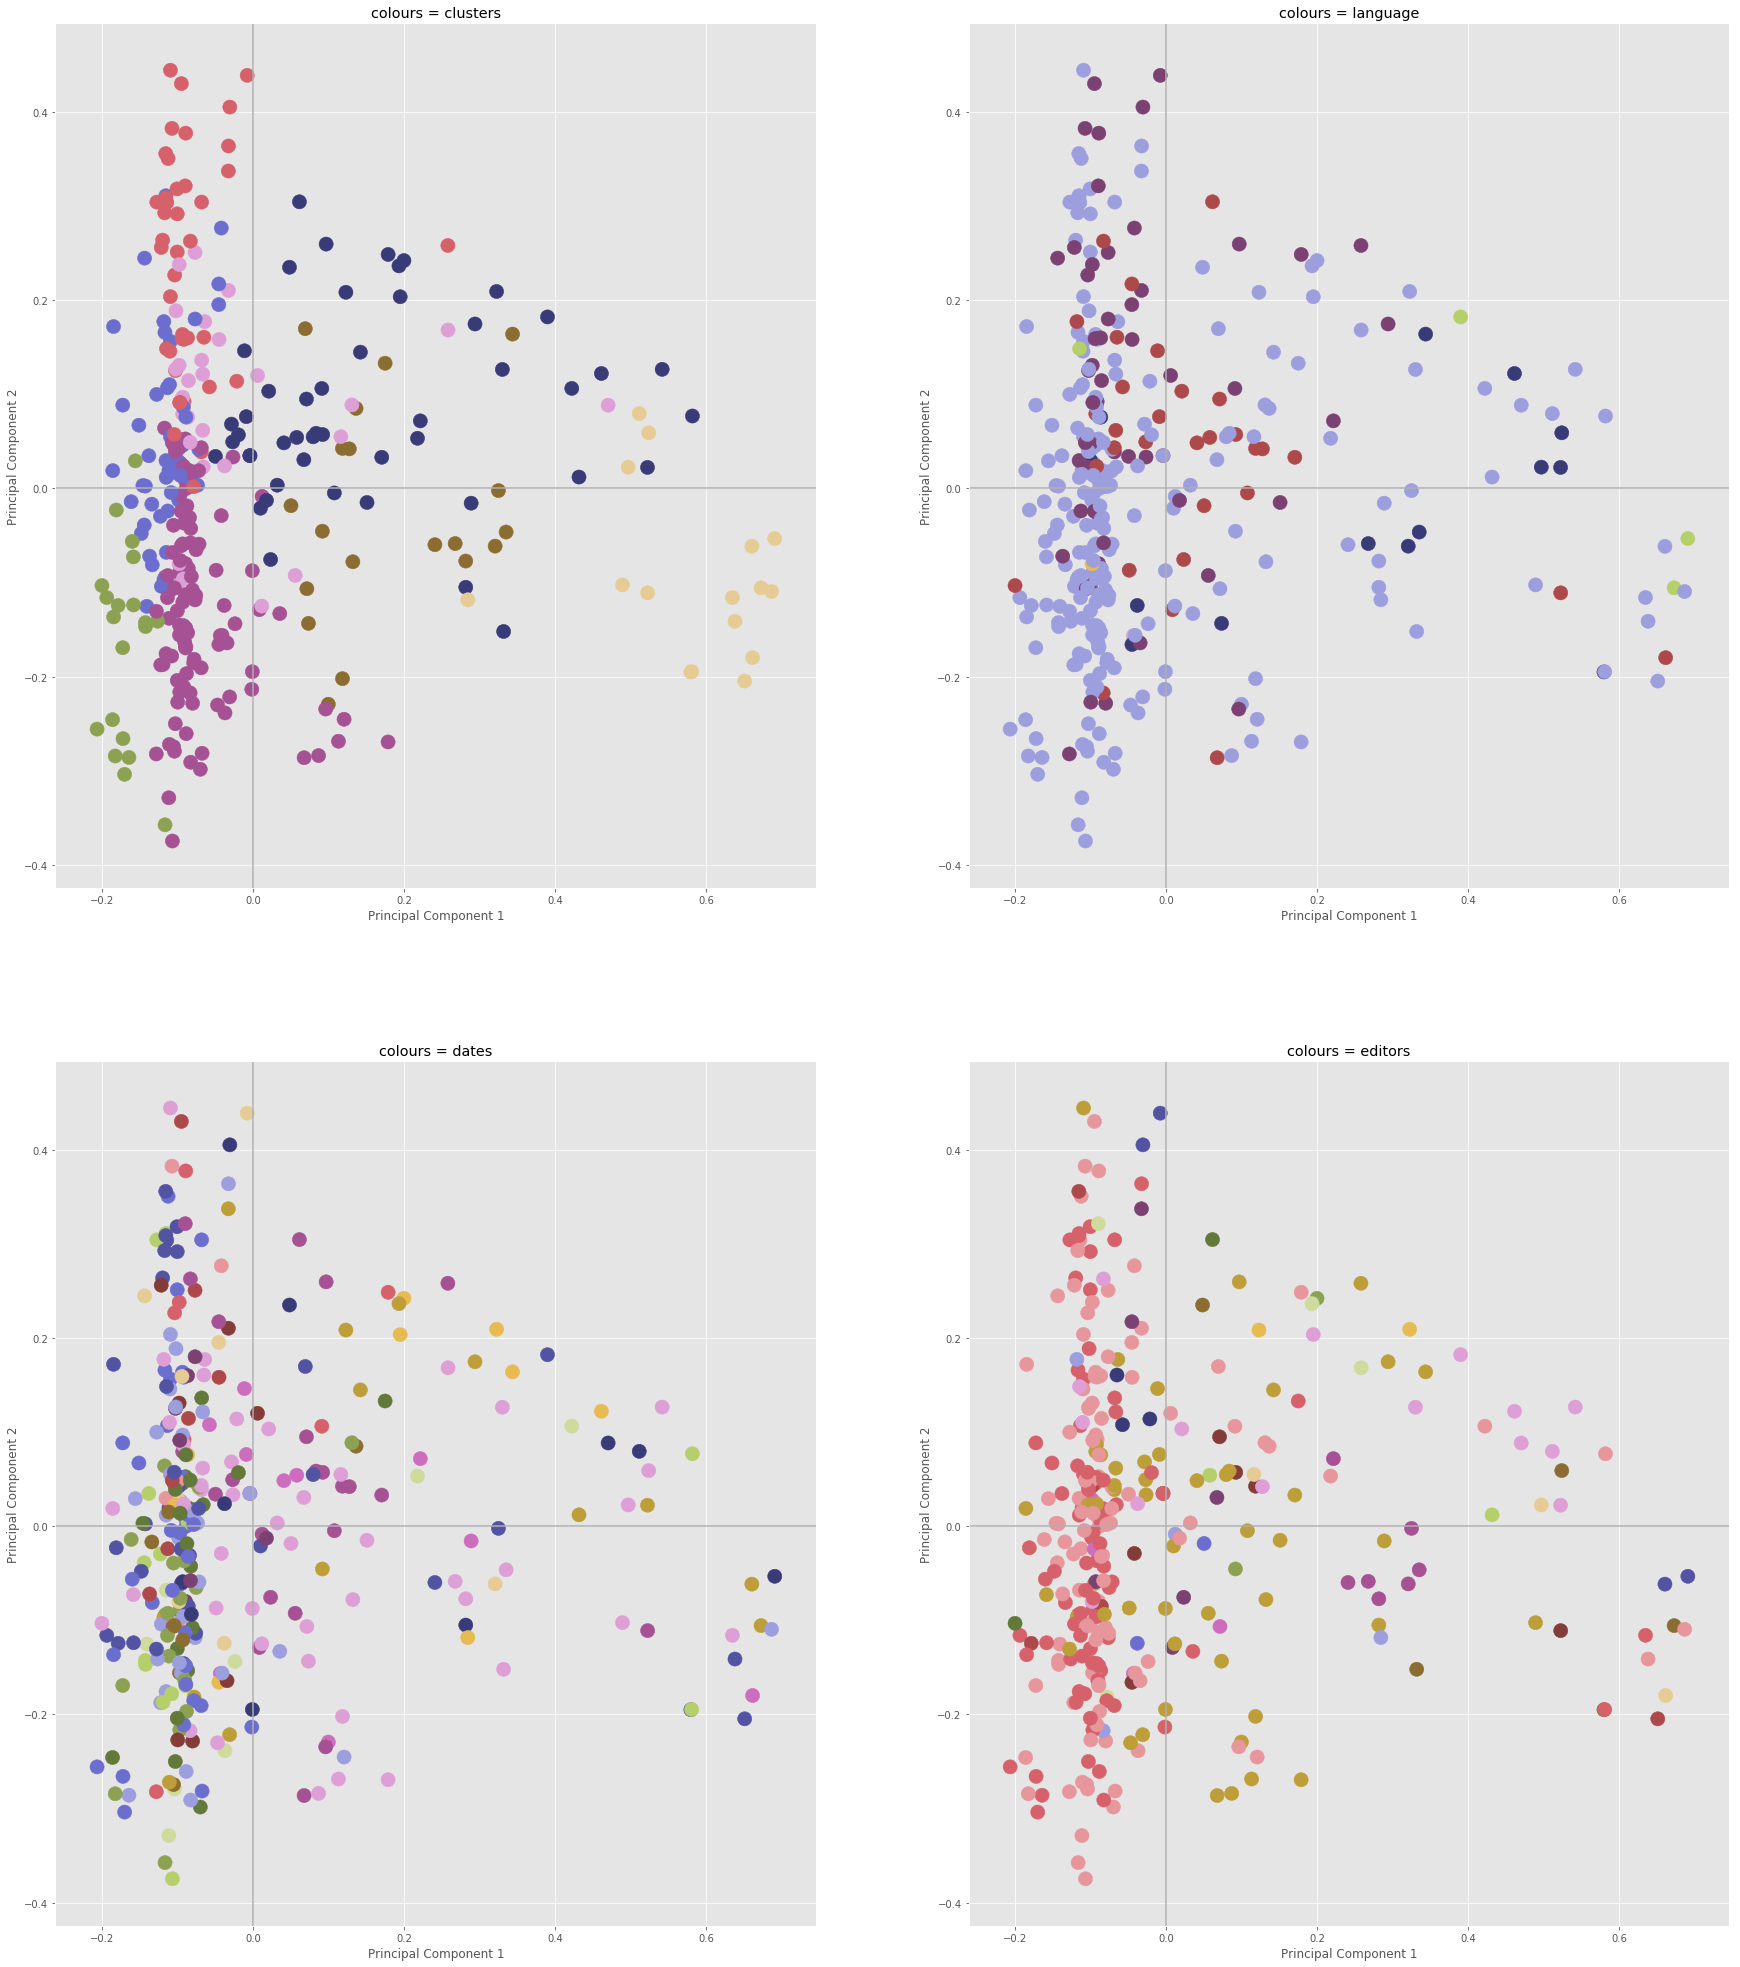

In [24]:
# subplots
fig, ((plot1, plot2), (plot3, plot4)) = plt.subplots(2, 2, sharex=False, sharey=False, figsize=(30, 35))

# colours = clusters
draw_subplots(X_2D_PCA, clf.labels_, plot1, n_clusters, plot_labels=False, labels=data['Title'], header='colours = clusters')

# colours = language
draw_subplots(X_2D_PCA, lang, plot2, n_clusters, plot_labels=False, labels=data['Title'], header='colours = language')

# colours = dates
draw_subplots(X_2D_PCA, date, plot3, n_clusters, plot_labels=False, labels=data['Title'], header='colours = dates')

# colours = editor
draw_subplots(X_2D_PCA, editor, plot4, n_clusters, plot_labels=False, labels=data['Title'], header='colours = editors')

### Case study: Cath Almaine

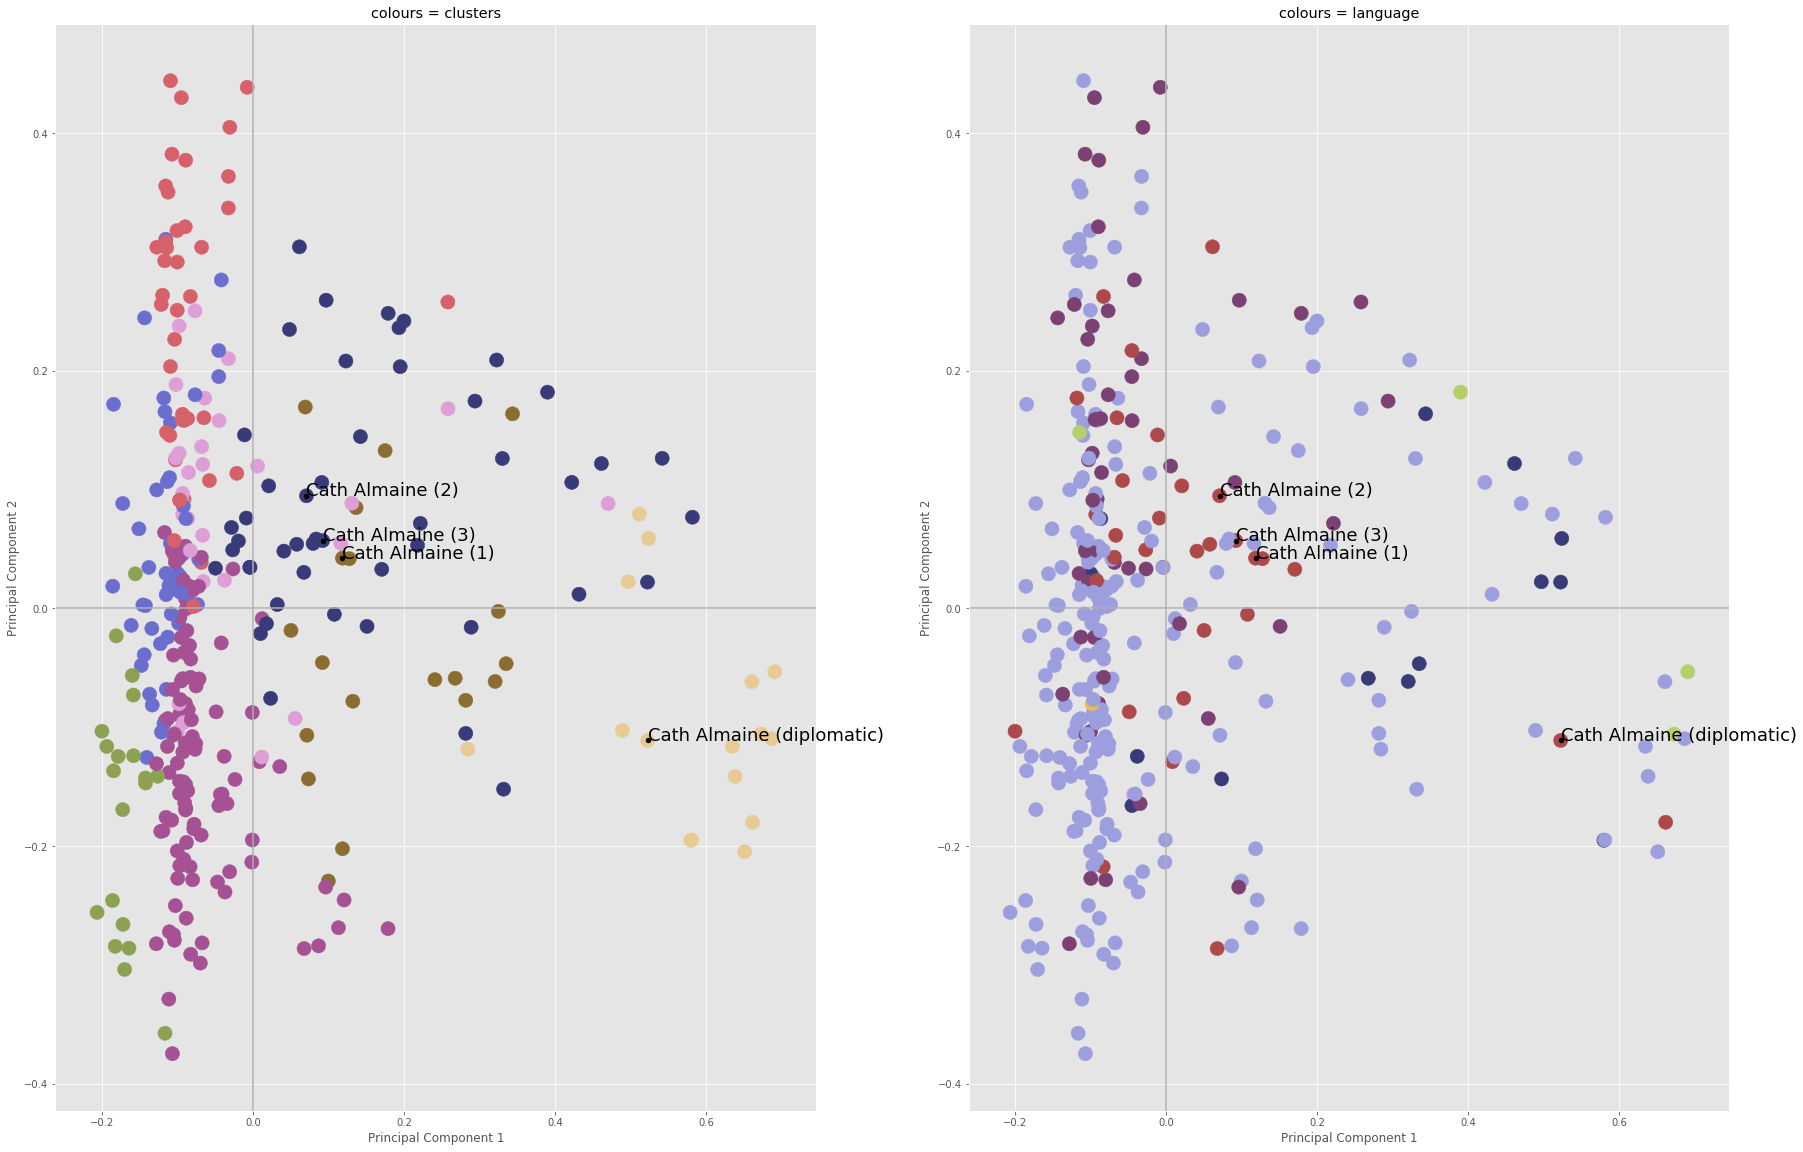

In [29]:
# subplots
fig, (almaine, almaine1) = plt.subplots(1, 2, sharex=False, sharey=False, figsize=(30, 20))

draw_subplots(X_2D_PCA, clf.labels_, almaine, n_clusters, plot_labels=True, labels=data['Title'], header='colours = clusters')

draw_subplots(X_2D_PCA, lang, almaine1, n_clusters, plot_labels=True, labels=data['Title'], header='colours = language')

### Case study: R. Thurneysen

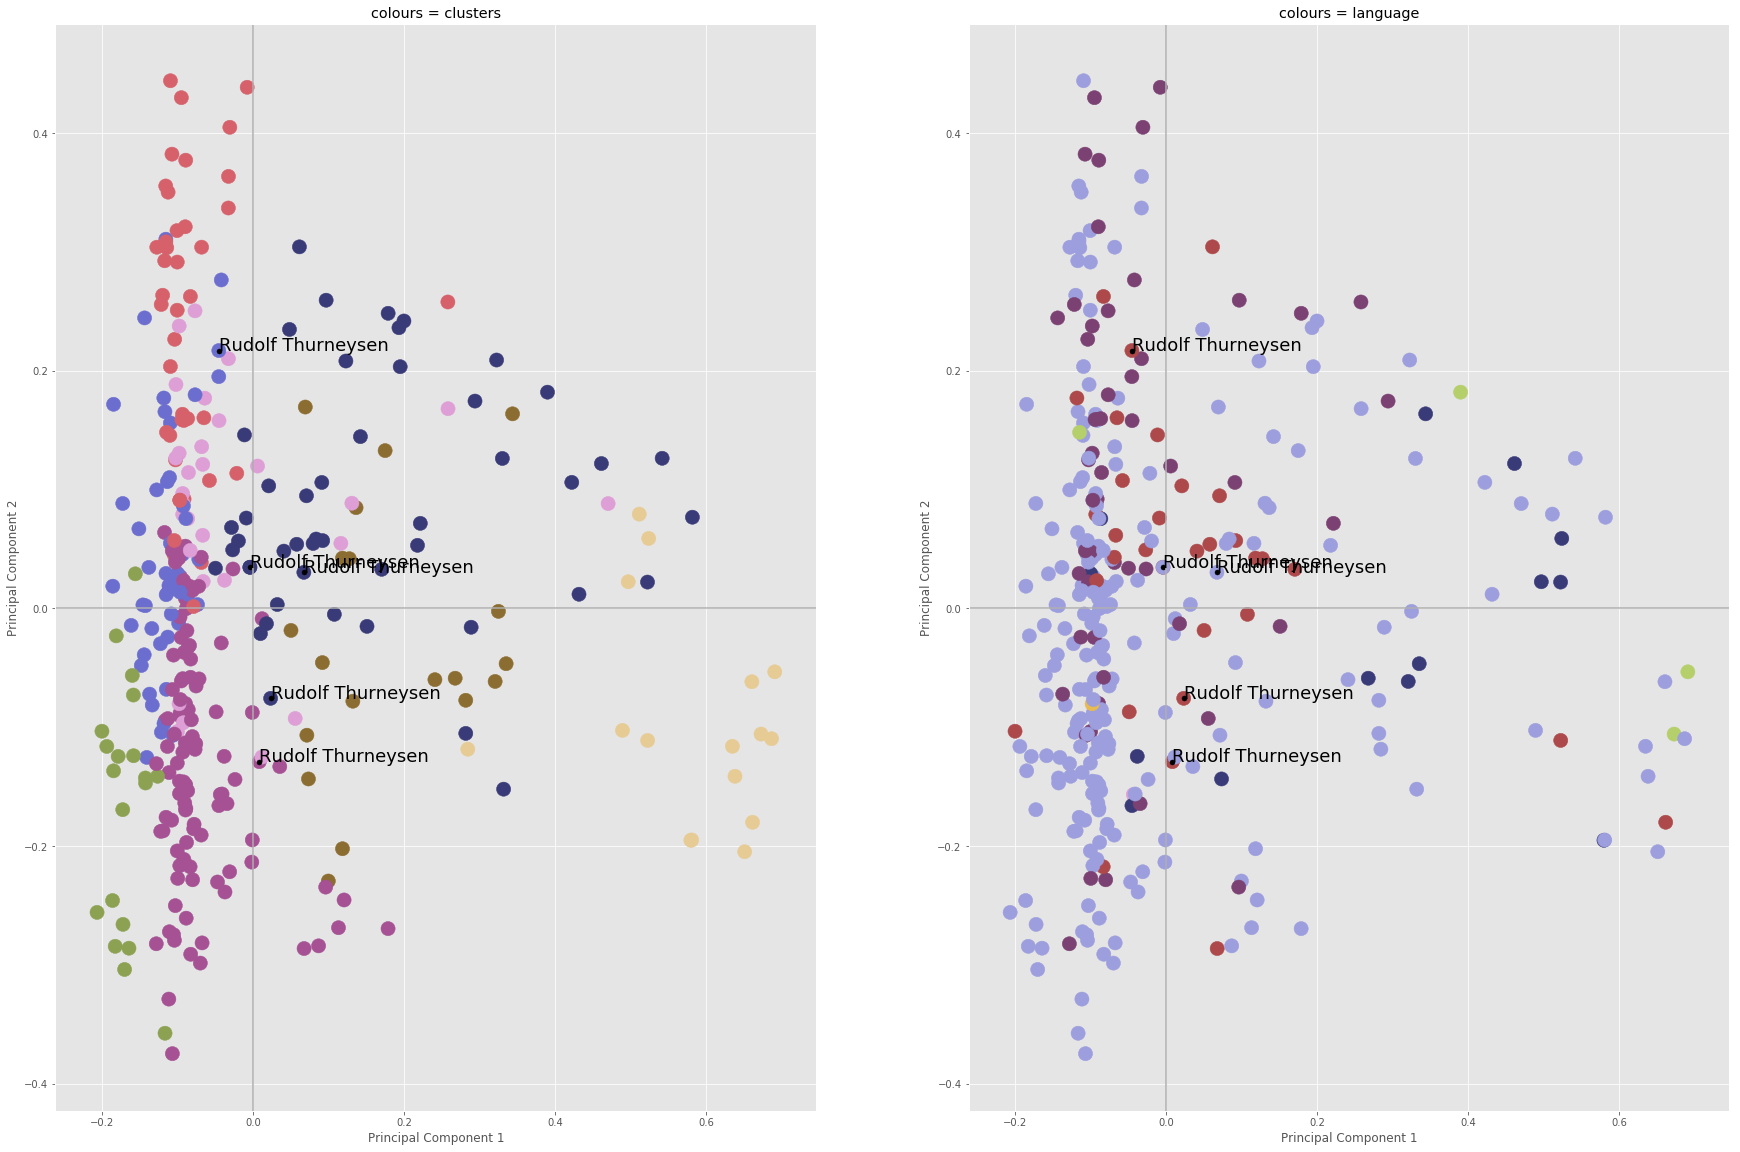

In [30]:
fig, (thurneysen, thurneysen1) = plt.subplots(1, 2, sharex=False, sharey=False, figsize=(30, 20))

draw_subplots(X_2D_PCA, clf.labels_, thurneysen, n_clusters, plot_labels=True, labels=data['Editor'], header='colours = clusters')

draw_subplots(X_2D_PCA, lang, thurneysen1, n_clusters, plot_labels=True, labels=data['Editor'], header='colours = language')

## LSA
Reducing dimensionality with LSA

In [31]:
svd = TruncatedSVD(n_components=2)
X_2D_SVD = svd.fit_transform(X.todense())

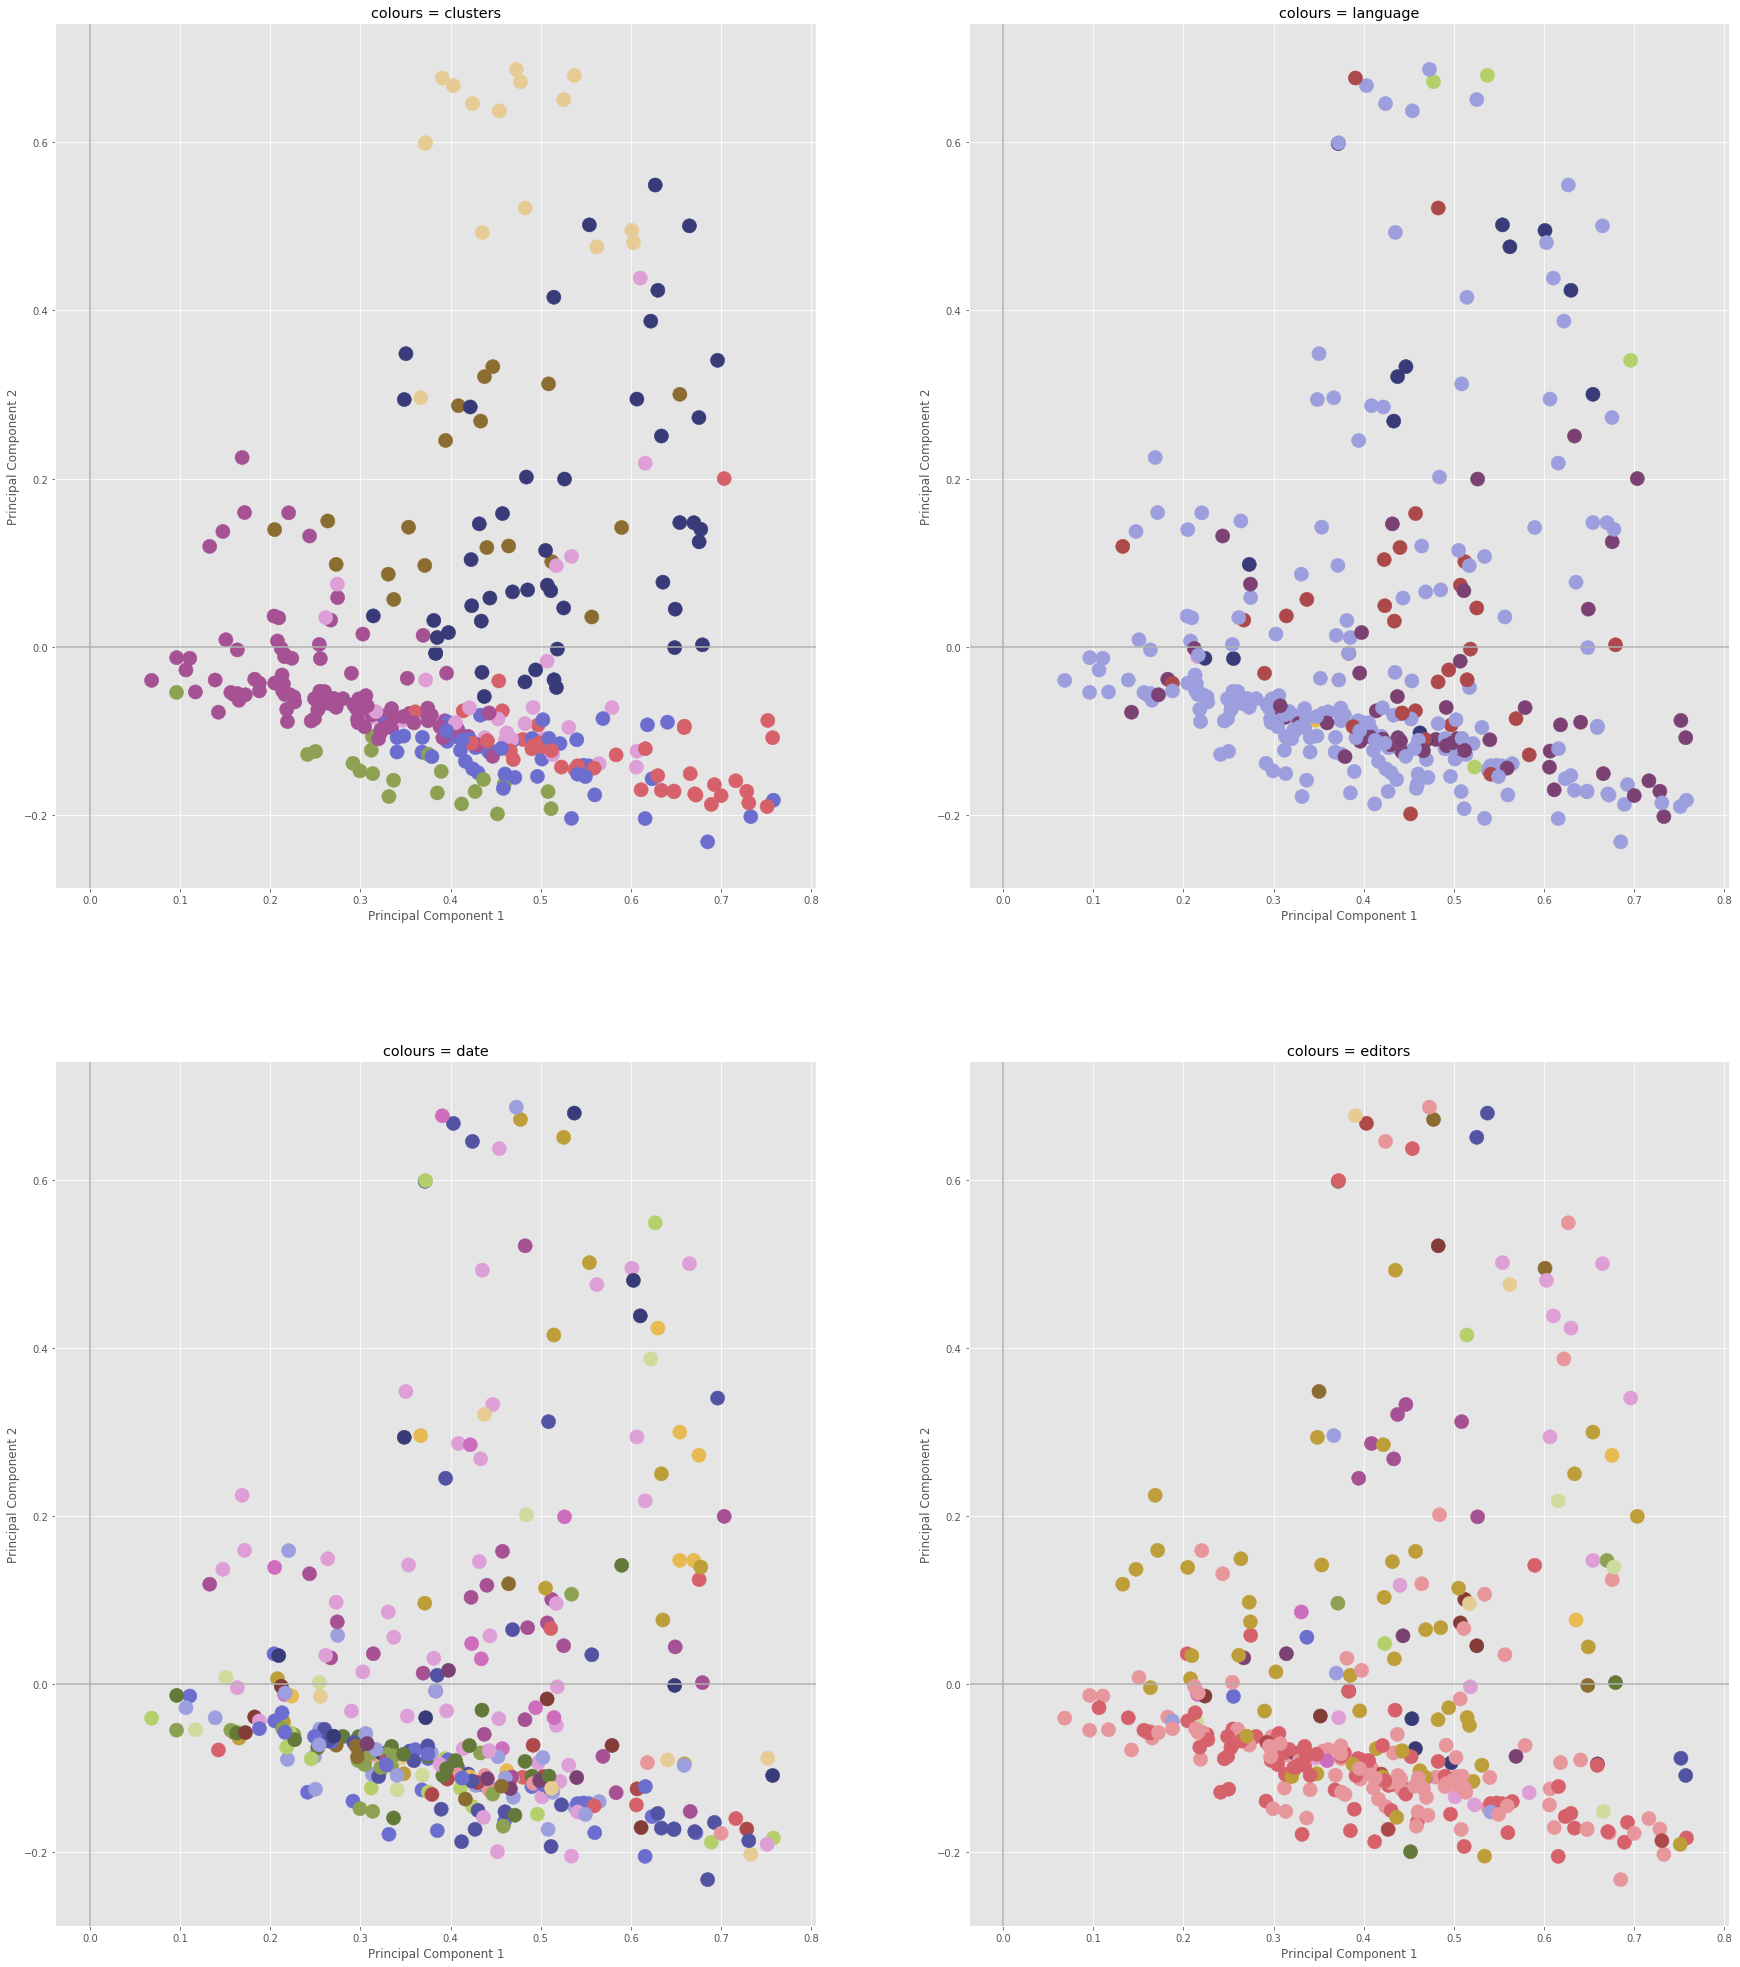

In [32]:
# subplots
fig, ((plot1, plot2), (plot3, plot4)) = plt.subplots(2, 2, sharex=False, sharey=False, figsize=(30, 35))

# colours = clusters
draw_subplots(X_2D_SVD, clf.labels_, plot1, n_clusters, header='colours = clusters', plot_centers=False, cmap='tab20b')

# colours = language
draw_subplots(X_2D_SVD, lang, plot2, n_clusters, header='colours = language', plot_centers=False, cmap='tab20b')

# colours = dates
draw_subplots(X_2D_SVD, date, plot3, n_clusters, header='colours = date', plot_centers=False, cmap='tab20b')

# colours = editor
draw_subplots(X_2D_SVD, editor, plot4, n_clusters, header='colours = editors', plot_centers=False, cmap='tab20b')

### Case study: Cath Almaine

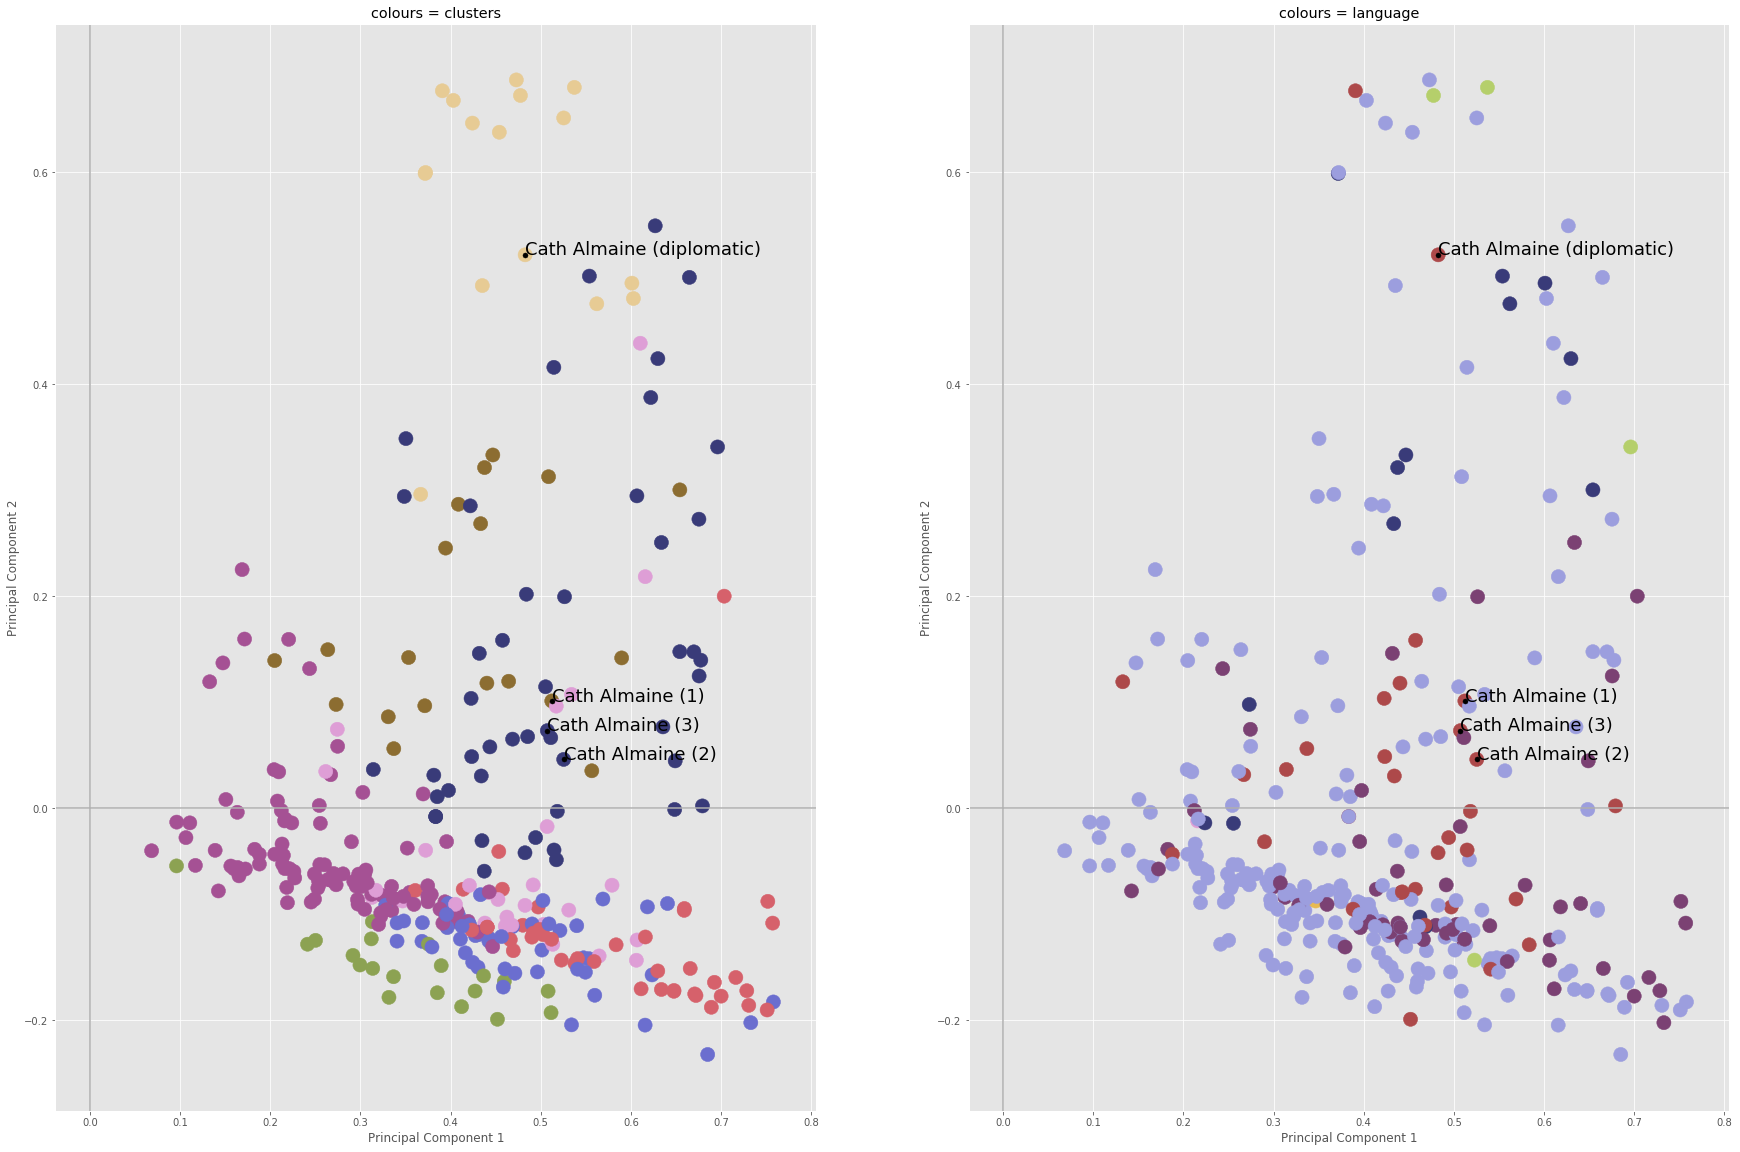

In [37]:
# subplots
fig, (almaine, almaine1) = plt.subplots(1, 2, sharex=False, sharey=False, figsize=(30, 20))

draw_subplots(X_2D_SVD, clf.labels_, almaine, n_clusters, plot_labels=True, labels=data['Title'], header='colours = clusters')

draw_subplots(X_2D_SVD, lang, almaine1, n_clusters, plot_labels=True, labels=data['Title'], header='colours = language')

### Case study: R. Thurneysen

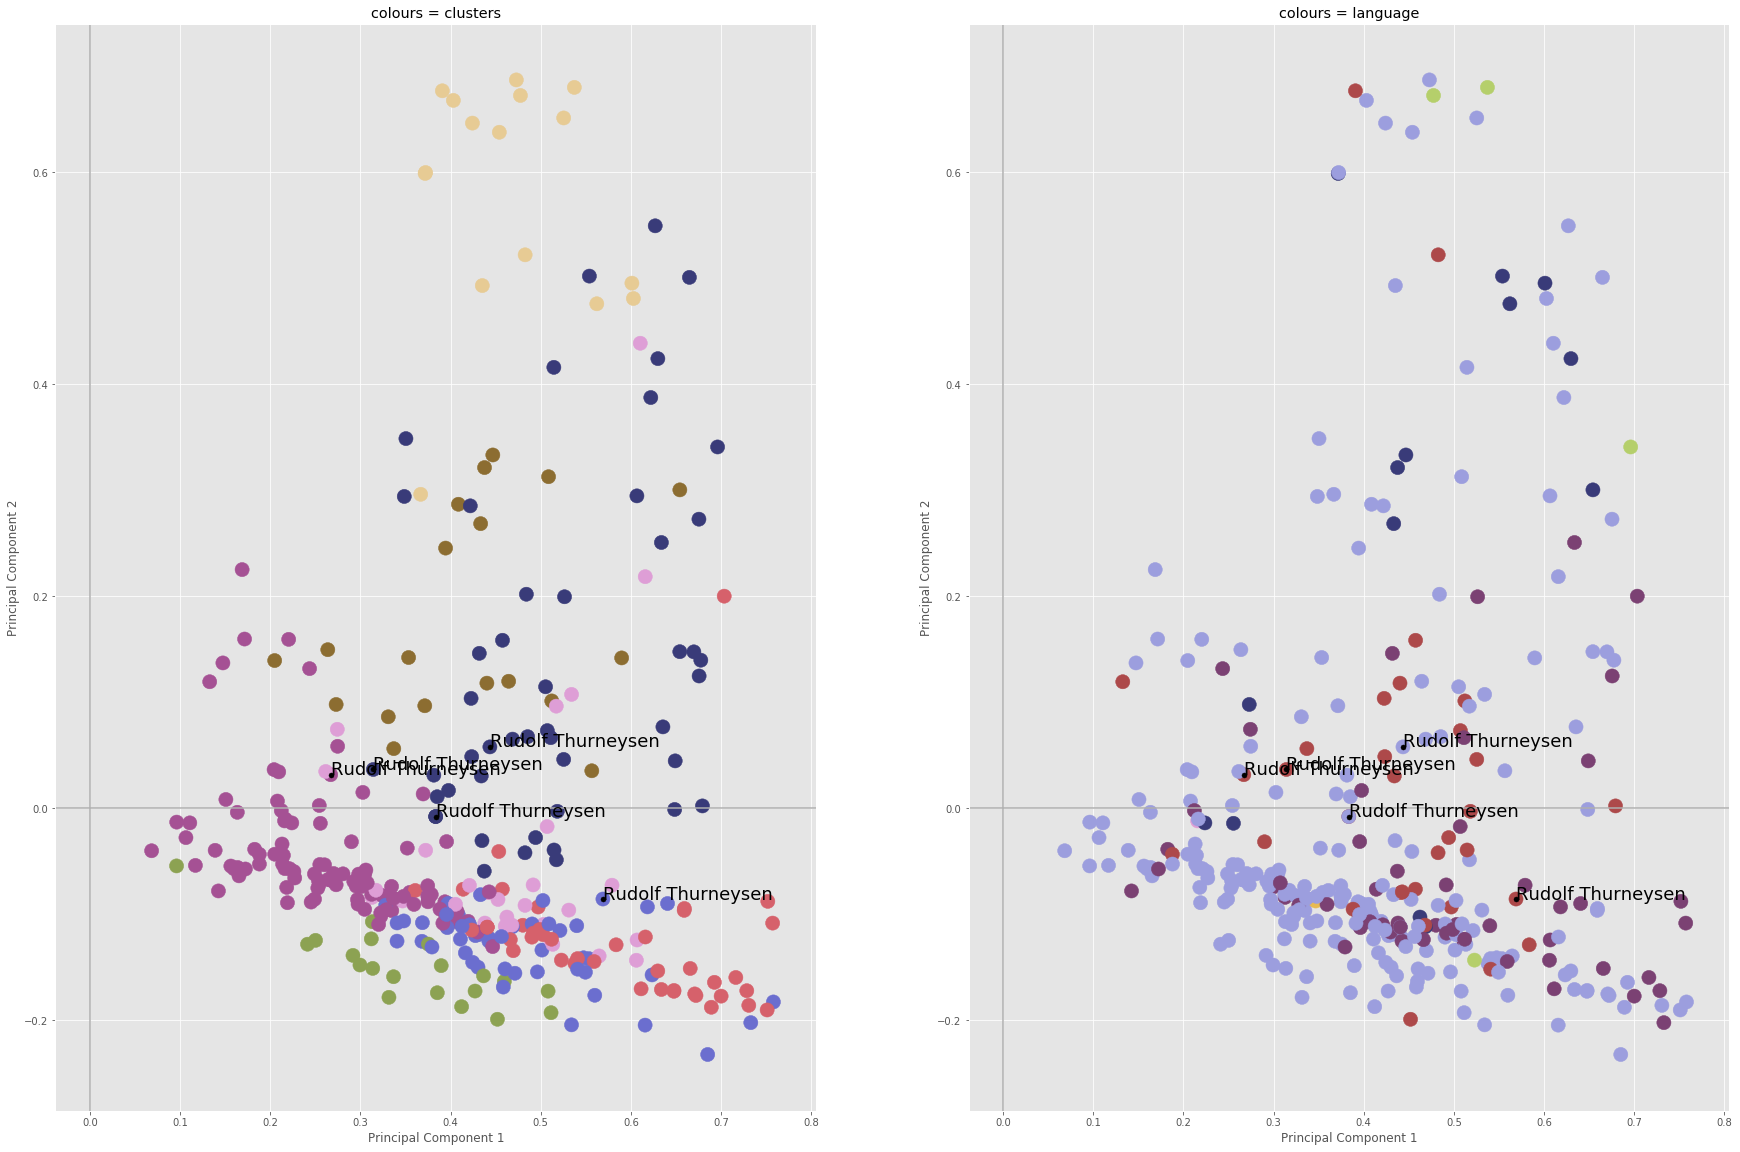

In [38]:
fig, (thurneysen, thurneysen1) = plt.subplots(1, 2, sharex=False, sharey=False, figsize=(30, 20))

draw_subplots(X_2D_SVD, clf.labels_, thurneysen, n_clusters, plot_labels=True, labels=data['Editor'], header='colours = clusters')

draw_subplots(X_2D_SVD, lang, thurneysen1, n_clusters, plot_labels=True, labels=data['Editor'], header='colours = language')

## LSA + t-SNE
Combining linear and non-linear methods of dimensionality reduction.

In [40]:
from sklearn.manifold import TSNE

svd10 = TruncatedSVD(n_components=10)
X_10_SVD = svd10.fit_transform(X.todense())
X_embedded = TSNE(n_components=2, perplexity=40, verbose=2).fit_transform(X_10_SVD)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 329 samples in 0.072s...
[t-SNE] Computed neighbors for 329 samples in 0.038s...
[t-SNE] Computed conditional probabilities for sample 329 / 329
[t-SNE] Mean sigma: 0.144231
[t-SNE] Computed conditional probabilities in 0.089s
[t-SNE] Iteration 50: error = 60.9537735, gradient norm = 0.5097962 (50 iterations in 0.299s)
[t-SNE] Iteration 100: error = 61.5727463, gradient norm = 0.5129701 (50 iterations in 0.140s)
[t-SNE] Iteration 150: error = 60.2203102, gradient norm = 0.5378749 (50 iterations in 0.145s)
[t-SNE] Iteration 200: error = 61.4265556, gradient norm = 0.5271550 (50 iterations in 0.151s)
[t-SNE] Iteration 250: error = 62.0604324, gradient norm = 0.5138277 (50 iterations in 0.153s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 62.060432
[t-SNE] Iteration 300: error = 0.6813151, gradient norm = 0.0020960 (50 iterations in 0.121s)
[t-SNE] Iteration 350: error = 0.5668752, gradient norm = 0.0027120 

### colours = clusters

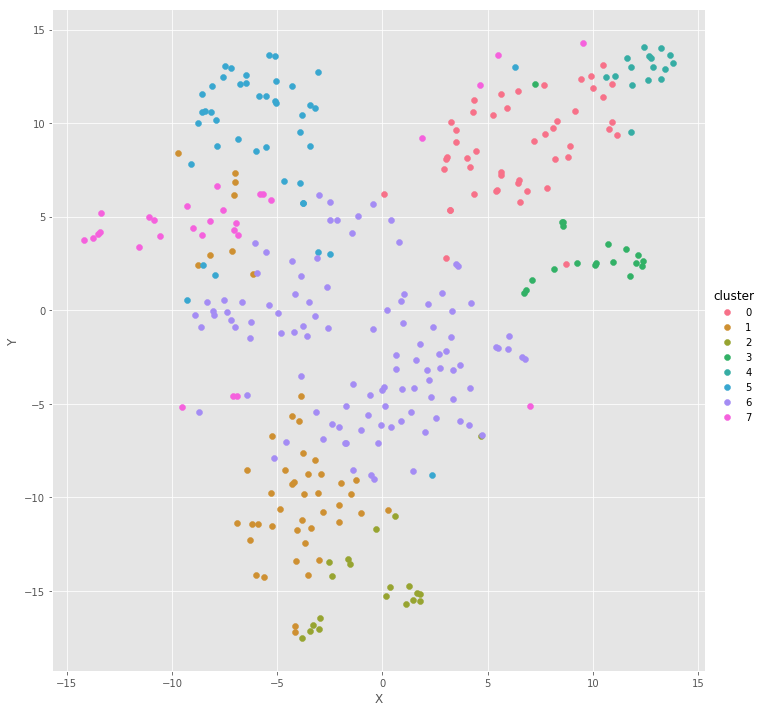

In [44]:
import seaborn as sns
df = pd.DataFrame({'X': X_embedded[:, 0], 'Y': X_embedded[:, 1], 'cluster' : data['Spectral']})
sns.FacetGrid(df, hue="cluster", height=10).map(plt.scatter, "X", "Y").add_legend()

### colours = language

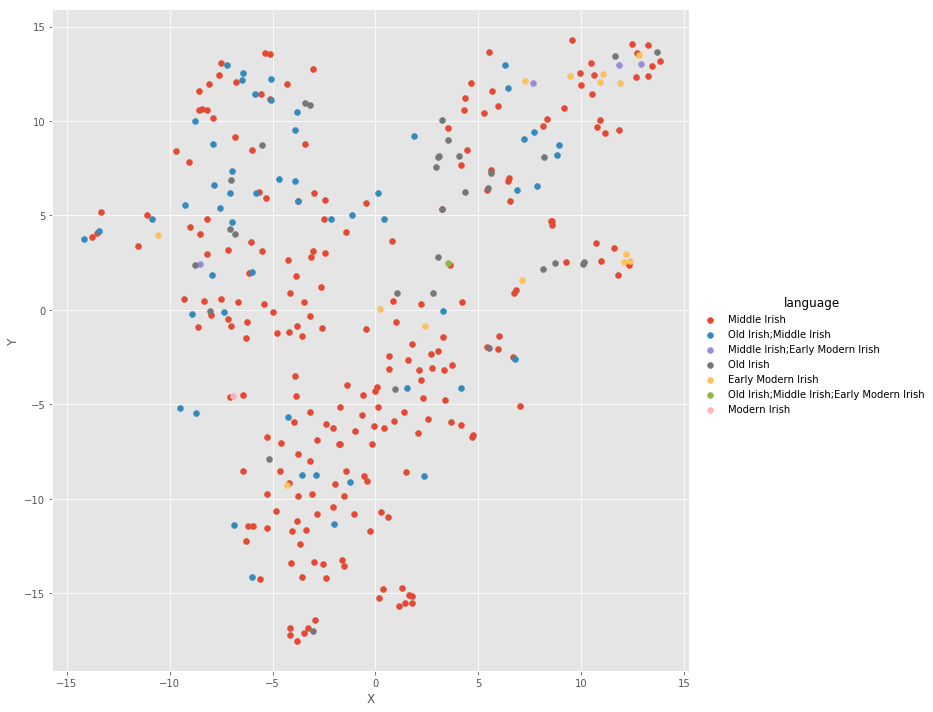

In [45]:
df2 = pd.DataFrame({'X': X_embedded[:, 0], 'Y': X_embedded[:, 1], 'language' : data['Language']})
sns.FacetGrid(df2, hue="language", height=10).map(plt.scatter, "X", "Y").add_legend()

### colours = editor

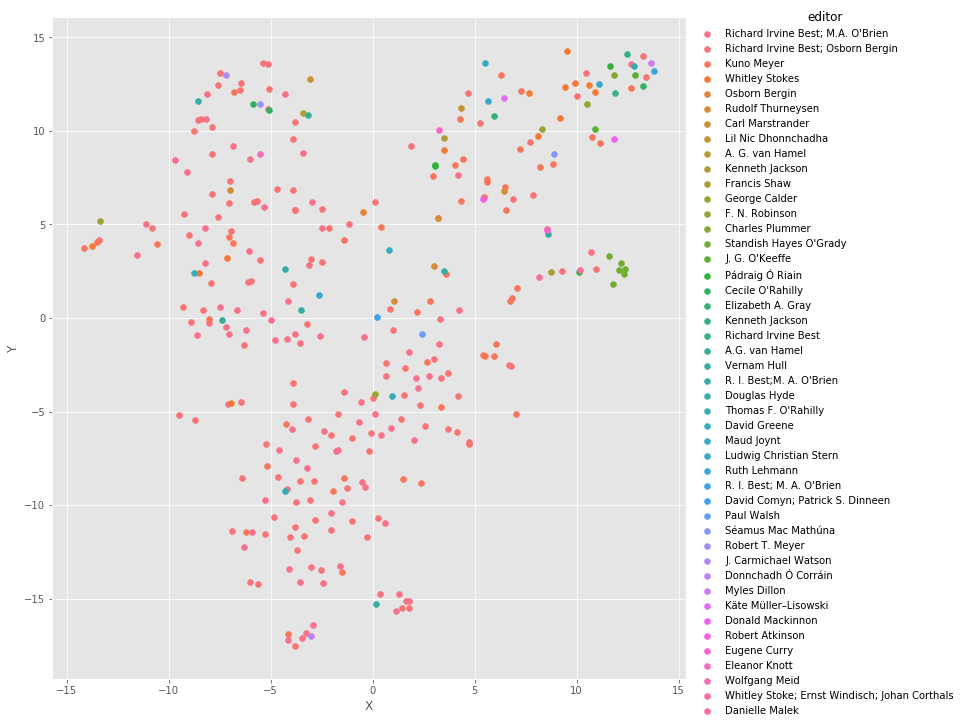

In [46]:
df3 = pd.DataFrame({'X': X_embedded[:, 0], 'Y': X_embedded[:, 1], 'editor' : data['Editor']})
sns.FacetGrid(df3, hue="editor", height=10).map(plt.scatter, "X", "Y").add_legend()

## PCA + t-SNE

Combining linear and non-linear methods of dimensionality reduction. 

In [47]:
pca5 = PCA(n_components=5)
X_5_PCA = pca5.fit_transform(X.todense())
X_embedded_2 = TSNE(n_components=2, perplexity=40, verbose=2).fit_transform(X_5_PCA)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 329 samples in 0.001s...
[t-SNE] Computed neighbors for 329 samples in 0.008s...
[t-SNE] Computed conditional probabilities for sample 329 / 329
[t-SNE] Mean sigma: 0.100478
[t-SNE] Computed conditional probabilities in 0.026s
[t-SNE] Iteration 50: error = 59.7883186, gradient norm = 0.5372266 (50 iterations in 0.147s)
[t-SNE] Iteration 100: error = 61.5284119, gradient norm = 0.4655759 (50 iterations in 0.185s)
[t-SNE] Iteration 150: error = 59.4151573, gradient norm = 0.5181805 (50 iterations in 0.150s)
[t-SNE] Iteration 200: error = 60.0142441, gradient norm = 0.5271206 (50 iterations in 0.154s)
[t-SNE] Iteration 250: error = 59.1338730, gradient norm = 0.5455131 (50 iterations in 0.146s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 59.133873
[t-SNE] Iteration 300: error = 0.4497905, gradient norm = 0.0018297 (50 iterations in 0.124s)
[t-SNE] Iteration 350: error = 0.3939269, gradient norm = 0.0028575 

### colours = clusters 

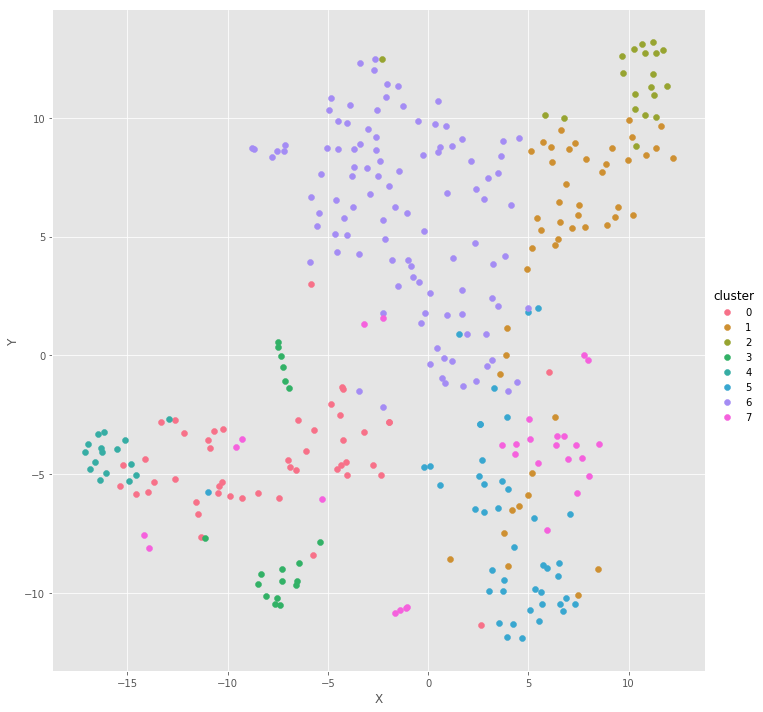

In [48]:
df4 = pd.DataFrame({'X': X_embedded_2[:, 0], 'Y': X_embedded_2[:, 1], 'cluster' : data['Spectral']})
sns.FacetGrid(df4, hue="cluster", height=10).map(plt.scatter, "X", "Y").add_legend()

###  colours = language

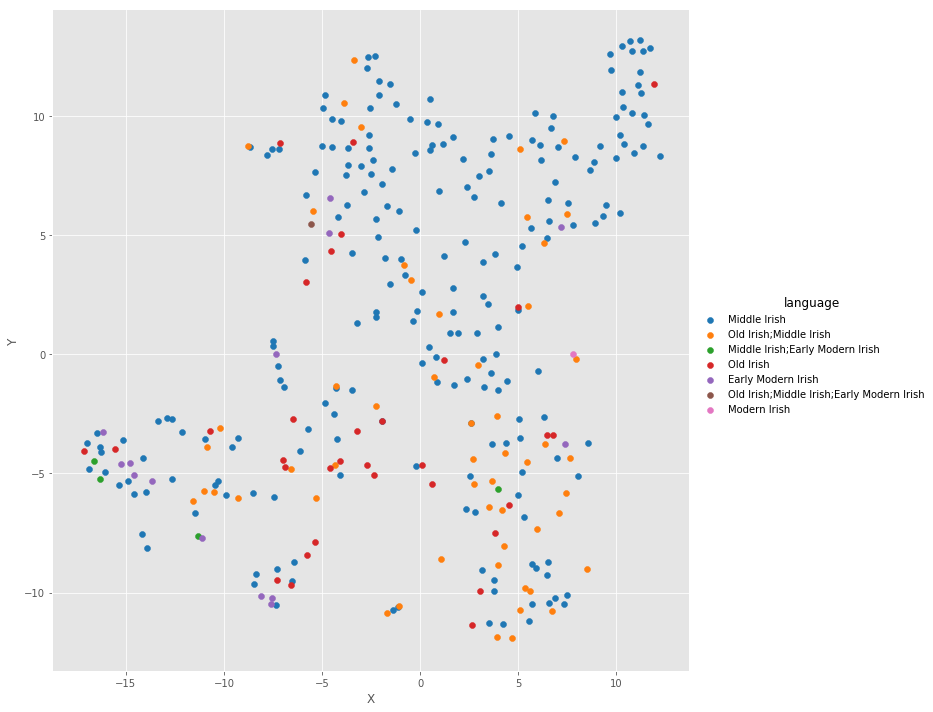

In [49]:
sns.set_palette('tab10')

df5 = pd.DataFrame({'X': X_embedded_2[:, 0], 'Y': X_embedded_2[:, 1], 'language' : data['Language']})
sns.FacetGrid(df5, hue="language", height=10).map(plt.scatter, "X", "Y").add_legend()

### colours = editor

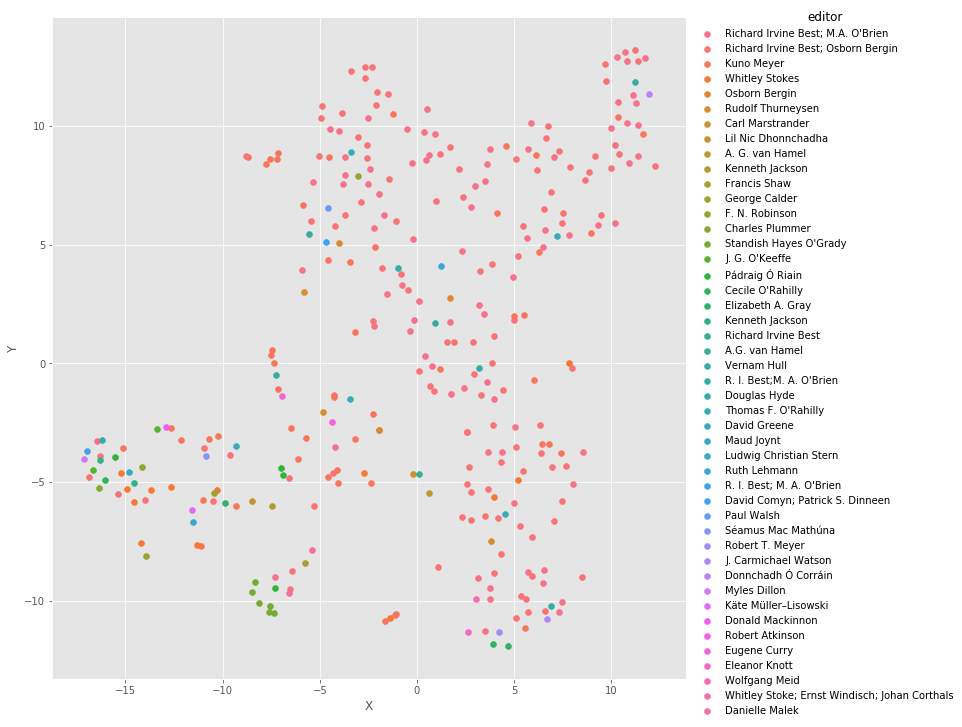

In [50]:
df6 = pd.DataFrame({'X': X_embedded_2[:, 0], 'Y': X_embedded_2[:, 1], 'editor' : data['Editor']})
sns.FacetGrid(df6, hue="editor", height=10).map(plt.scatter, "X", "Y").add_legend()

## Interactive visualization 

In [51]:
namedate = []

for n, d in zip(data['Title'].tolist(), data['Dates'].tolist()):
    nd = '%s, %s' % (n, d)
    namedate.append(nd)
    
namedate[:5]

['A Chloch thall for elaid úair, 1150–1216',
 'A Chormaic coisc do maicni, 1150–1212',
 'A Chóicid chóem Chairpri chrúaid, 1150–1224',
 'A Gillu gairm n–ilgrada , 1150–1195',
 'A Maccáin ná cí, 1150–1206']

#### Offline

In [52]:
# offline

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly import tools
import plotly.plotly as py
import plotly.graph_objs as go

init_notebook_mode(connected=True)


points = go.Scatter(
        x = X_2D_SVD[:,0],
        y = X_2D_SVD[:,1],
        name = 'Texts', 
        mode='markers',
        marker=dict(color=clf.labels_, colorscale='Viridis', size=10),
        text=namedate,
        textposition='bottom right'
)


# center_points = go.Scatter(
#          x = centers[:,0], 
#          y = centers[:,1], 
#          mode = 'markers', 
#          marker = dict(size=10, color='red', symbol='cross'),
#          name = 'Centroids'
# )


fig = tools.make_subplots(rows=1, cols=1)

fig.append_trace(points, 1, 1)
# fig.append_trace(center_points, 1, 1)

fig['layout'].update(
                     title={'text': 'Early Irish Texts', 'font': {'size': 25}}, 
                     xaxis={'title':'Principal Component 1'}, 
                     yaxis={'title':'Principal Component 2'},
                     legend={'font': {'size': 20},
                             'bgcolor':'#f6f6f6'})
            
iplot(fig, filename='early_irish_clustering')

This is the format of your plot grid:
[ (1,1) x1,y1 ]



#### Online

Available here: https://plot.ly/~ancatmara/86/early-irish-texts/ 

In [46]:
# online

from plotly import tools
import plotly.plotly as py
import plotly.graph_objs as go

points = go.Scatter(
        x = X_2D_PCA[:,0],
        y = X_2D_PCA[:,1],
        name = 'Texts', 
        mode='markers',
        marker=dict(color=clf.labels_, colorscale='Viridis', size=10),
        text=namedate,
        textposition='bottom right'
)


# center_points = go.Scatter(
#          x = centers[:,0], 
#          y = centers[:,1], 
#          mode = 'markers', 
#          marker = dict(size=10, color='red', symbol='cross'),
#          name = 'Centroids'
# )


fig = tools.make_subplots(rows=1, cols=1)

fig.append_trace(points, 1, 1)
# fig.append_trace(center_points, 1, 1)

fig['layout'].update(
                     title={'text': 'Early Irish Texts', 'font': {'size': 25}}, 
                     xaxis={'title':'Principal Component 1'}, 
                     yaxis={'title':'Principal Component 2'},
                     legend={'font': {'size': 20},
                             'bgcolor':'#f6f6f6'})
            
py.iplot(fig, filename='early_irish_clustering')

This is the format of your plot grid:
[ (1,1) x1,y1 ]



D:\Anaconda3\lib\site-packages\IPython\core\display.py:689: UserWarning:

Consider using IPython.display.IFrame instead



## Dendrograms

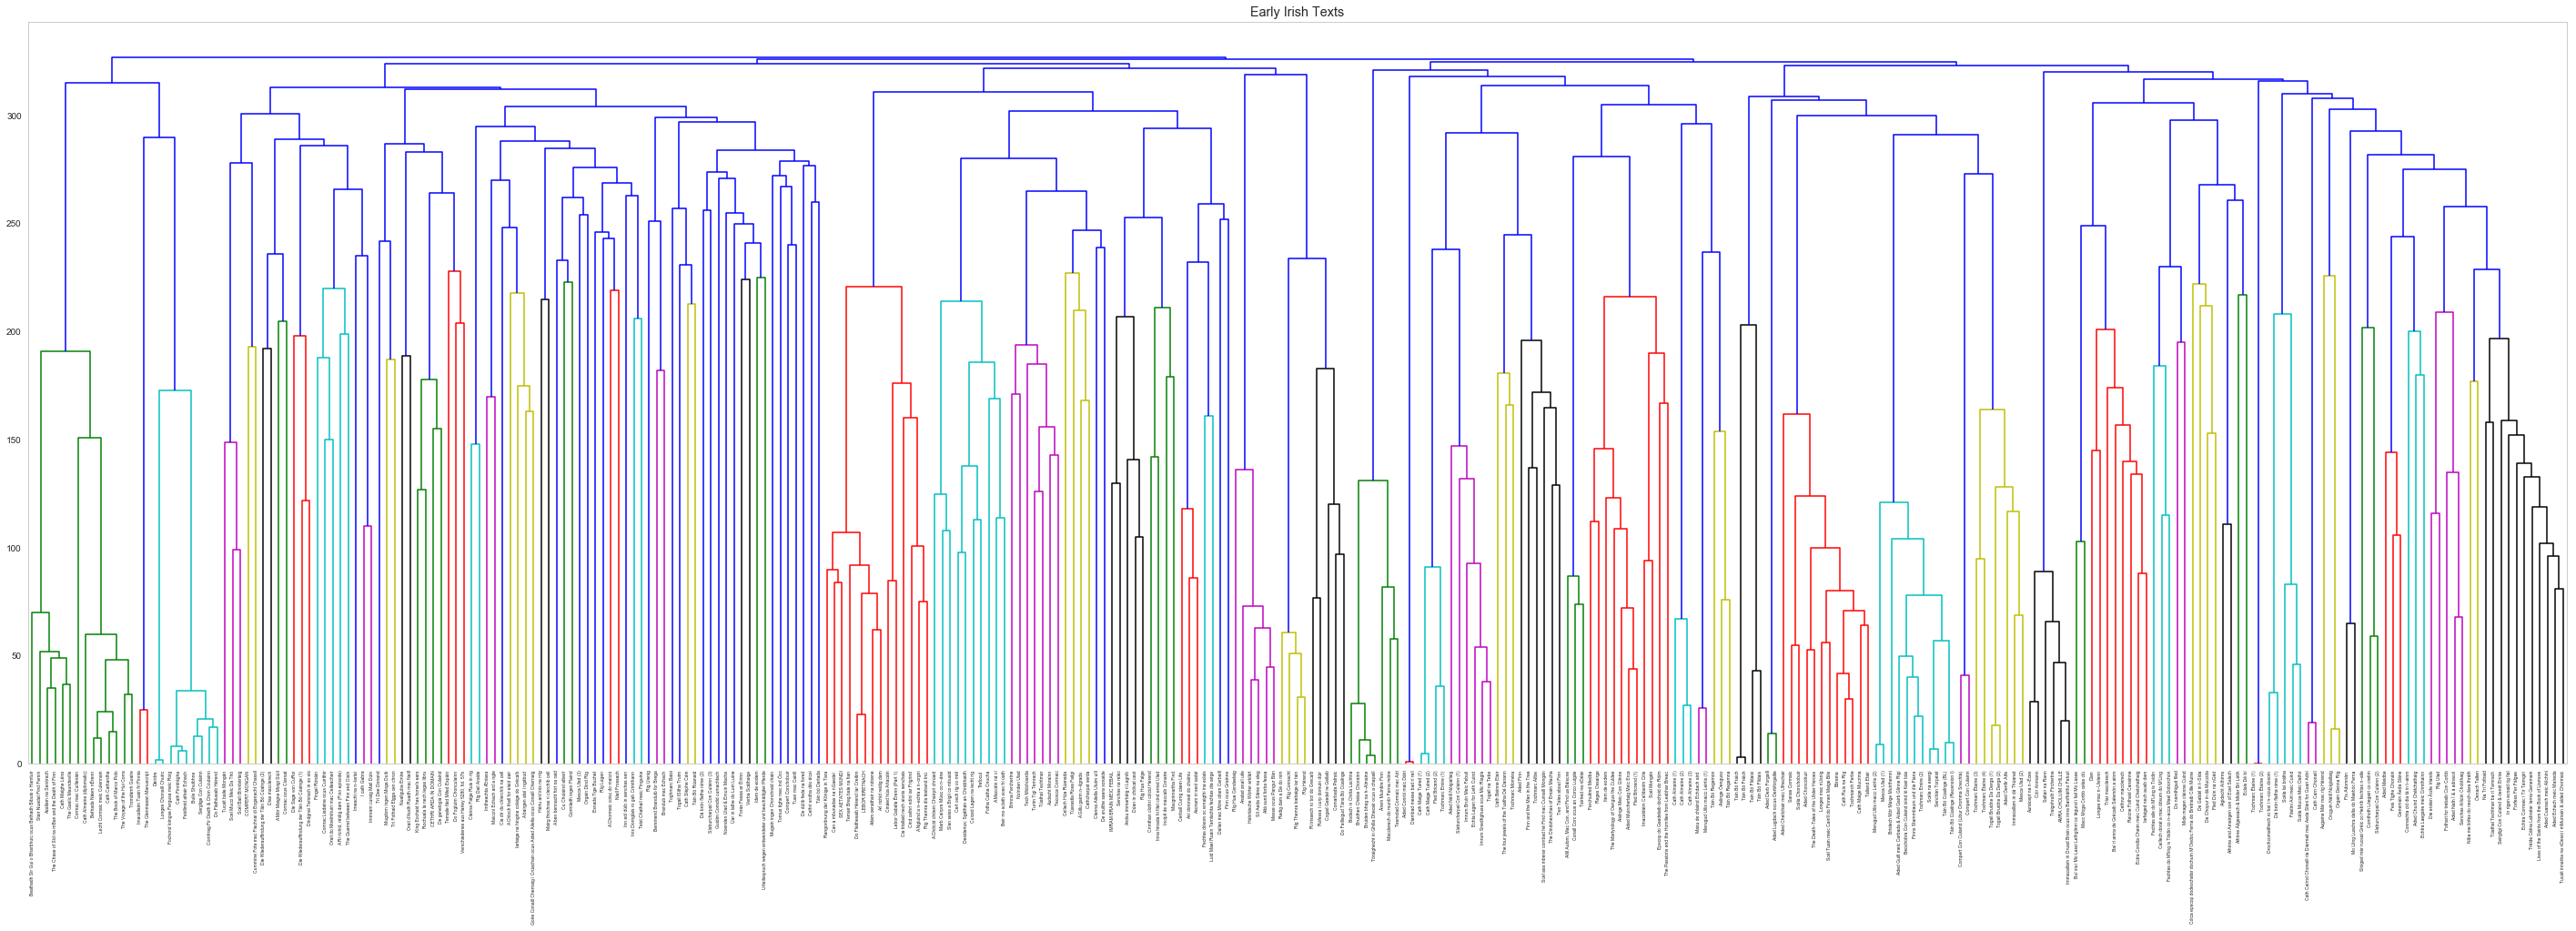

In [53]:
from scipy.cluster.hierarchy import dendrogram
import seaborn as sns

def plot_dendrogram(model, **kwargs):
    children = model.children_
    distance = np.arange(children.shape[0])
    no_of_observations = np.arange(2, children.shape[0]+2)
    linkage_matrix = np.column_stack([children, distance, no_of_observations]).astype(float)
    dendrogram(linkage_matrix, **kwargs)

clf3 = AgglomerativeClustering()
clf3.fit(X.toarray())

sns.set_style(style='whitegrid')
plt.figure(figsize = (50,15))
plt.grid(False)
plt.title('Early Irish Texts')
plot_dendrogram(clf3, labels=data['Title'].tolist())

plt.savefig('dendro.png', dpi=300)
plt.show()

### Interactive dendrograms
#### Offline

In [54]:
import plotly.figure_factory as ff

X_2D = pca.fit_transform(X.todense())
dendro = ff.create_dendrogram(X_2D, labels=data['Title'].tolist())
dendro['layout'].update(width=1000, height=500,
                     title={'text': 'Early Irish Texts', 'font': {'size': 25}}, 
                     font={'size': 10})
iplot(dendro, filename='dendro2')

#### Online
Available here: https://plot.ly/~ancatmara/84/early-irish-texts/

In [55]:
import plotly.figure_factory as ff

X_2D = pca.fit_transform(X.todense())
dendro = ff.create_dendrogram(X_2D, labels=data['Title'].tolist())
dendro['layout'].update(width=1000, height=500,
                     title={'text': 'Early Irish Texts', 'font': {'size': 25}}, 
                     font={'size': 10})
py.iplot(dendro, filename='dendro2')

D:\Anaconda3\lib\site-packages\IPython\core\display.py:689: UserWarning:

Consider using IPython.display.IFrame instead

